# Computation of Granularity Adjustments of MDB Portfolios

In [1]:
import numpy as np
from scipy.optimize import fsolve, minimize
import matplotlib.pyplot as plt 
import pandas as pd
import copy
from tqdm import tqdm
%load_ext autoreload
%autoreload 2
%aimport IS_misc_functions
from IS_misc_functions import *
from misc_functions import *
from actuarial_training import *
from MtM_training import *
from scipy.optimize import minimize

import warnings
warnings.filterwarnings("ignore")

# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers
# from tensorflow.keras import regularizers
# from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, MaxAbsScaler,normalize
# from sklearn.model_selection import train_test_split
# from sklearn.utils import shuffle

# Create Portfolios

Read in everything

In [2]:
by_country = pd.read_excel("MDB portfolios.xlsx", sheet_name='by country')
maturity = pd.read_excel("MDB portfolios.xlsx", sheet_name='maturity')
summary = pd.read_excel("MDB portfolios.xlsx", sheet_name='summary of current info')
comments = pd.read_excel("MDB portfolios.xlsx", sheet_name='comments')
rating = pd.read_excel("MDB portfolios.xlsx", sheet_name='rating')
transition_matrix_SP = pd.read_csv("transition_matrix_SP.csv",delimiter = ",",index_col = 0)
transition_matrix_RC = pd.read_csv("transition_matrix_RC.csv",delimiter = ";",index_col = 0)

Preprocessing the Data

### Display the S & P Transition Matrix

In [9]:
SP_dict = trans_matrix_to_dict(transition_matrix_SP)
transition_matrix_SP

,AAA,AA+,AA,AA-,A+,A,A-,BBB+,BBB,BBB-,BB+,BB,BB-,B+,B,B-,Cs,D
AAA,96.79,2.71,0.42,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.07,0.00,0.00,0.00,0.00,0.00,0.00
AA+,6.45,85.16,6.61,1.77,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
AA,0.00,6.22,85.17,6.74,0.52,0.42,0.10,0.52,0.00,0.00,0.00,0.31,0.00,0.00,0.00,0.00,0.00,0.00
AA-,0.00,0.00,7.82,83.45,7.16,0.17,0.50,0.17,0.00,0.17,0.44,0.00,0.00,0.11,0.00,0.00,0.00,0.00
A+,0.00,0.00,0.07,13.35,73.28,9.30,2.03,1.12,0.14,0.63,0.07,0.00,0.00,0.00,0.00,0.00,0.00,0.01
A,0.00,0.00,0.00,1.15,12.33,77.29,5.71,1.68,0.77,0.96,0.10,0.00,0.00,0.00,0.00,0.00,0.00,0.01
A-,0.00,0.00,0.00,0.00,0.94,11.47,77.82,6.94,0.41,1.57,0.67,0.16,0.00,0.00,0.00,0.00,0.00,0.02
BBB+,0.00,0.00,0.00,0.00,0.00,2.16,12.39,70.86,11.24,2.41,0.60,0.24,0.06,0.00,0.00,0.00,0.00,0.04
BBB,0.00,0.00,0.00,0.00,0.00,0.00,1.87,16.60,68.05,11.16,0.99,0.11,0.00,0.50,0.22,0.11,0.33,0.06
BBB-,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.93,14.94,74.69,6.50,2.13,0.27,0.08,0.15,0.12,0.08,0.11


### Display the PCT-adjusted  S & P Transition Matrix

In [10]:
RC_dict = trans_matrix_to_dict(transition_matrix_RC)
transition_matrix_RC

,AAA,AA+,AA,AA-,A+,A,A-,BBB+,BBB,BBB-,BB+,BB,BB-,B+,B,B-,Cs,D
AAA,96.79,2.71,0.42,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.07,0.00,0.00,0.00,0.00,0.00,0.00
AA+,6.45,85.16,6.61,1.77,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
AA,0.00,6.22,85.17,6.74,0.52,0.42,0.10,0.52,0.00,0.00,0.00,0.31,0.00,0.00,0.00,0.00,0.00,0.00
AA-,0.00,0.00,7.82,83.45,7.16,0.17,0.50,0.17,0.00,0.17,0.44,0.00,0.00,0.11,0.00,0.00,0.00,0.00
A+,0.00,0.00,0.07,13.35,73.28,9.30,2.03,1.12,0.14,0.63,0.07,0.00,0.00,0.00,0.00,0.00,0.00,0.00
A,0.00,0.00,0.00,1.15,12.33,77.30,5.71,1.68,0.77,0.96,0.10,0.00,0.00,0.00,0.00,0.00,0.00,0.00
A-,0.00,0.00,0.00,0.00,0.94,11.47,77.83,6.94,0.41,1.57,0.67,0.16,0.00,0.00,0.00,0.00,0.00,0.01
BBB+,0.00,0.00,0.00,0.00,0.00,2.16,12.40,70.87,11.25,2.41,0.60,0.24,0.06,0.00,0.00,0.00,0.00,0.01
BBB,0.00,0.00,0.00,0.00,0.00,0.00,1.87,16.61,68.08,11.17,0.99,0.11,0.00,0.50,0.22,0.11,0.33,0.02
BBB-,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.93,14.95,74.75,6.51,2.13,0.27,0.08,0.15,0.12,0.08,0.03


Create Dictionaries to assign PDs to the considered countries

In [11]:
#Small Tolerance to avoid 0s
tolerance = 10e-10

# list of banks
bank_names = list(summary.iloc[:,0])

# Exclude EIB and NIB from being considered
bank_names = [b for b in bank_names if b != "EIB" and b!= "NIB"]


# SP Rating of Countries
country_sp = {rating["Country"][i].lower().replace(" ", ""): 
              str(rating["sp_cb"][i]).replace(" ", "")  for i in range(len(rating["sp_cb"]))}

def create_PD_dict(transition_matrix,unrated_b_minus = True):
    country_dict = country_sp #copy.copy(country_sp)

    # The PDs of Rating Classes
    Rating_PD = {transition_matrix.index[i]: np.maximum(transition_matrix["D"][i],tolerance)  for i in range(len(transition_matrix.index))}

    # Companies with D rating are not in default wrt other MDBs:
    Rating_PD["D"] = Rating_PD["Cs"]
    Rating_PD["SD"] = Rating_PD["Cs"]
    
    if unrated_b_minus:
        for country_rating in set(country_dict.values()):
            if country_rating in ["C","CC","CCC-","CCC","CCC+"]:
                Rating_PD[country_rating] = Rating_PD["Cs"]
            if country_rating in ['0',0]:
                Rating_PD[country_rating] = Rating_PD["B-"] 

#         for country_rating in set(country_dict.values()):
#             if country_rating not in Rating_PD.keys():
#                 Rating_PD[country_rating] = "nan"

        for country in country_dict:
            if country_dict[country] in ["C","CC","CCC-","CCC","CCC+"]:
                country_dict[country] = "Cs"
            if country_dict[country] in ['0',0]:
                country_dict[country] = "B-"
    
    elif unrated_b_minus == False:

        # Adjust the PDs further 
        for country_rating in set(country_dict.values()):
            if country_rating in ["C","CC",'0',0,"CCC-","CCC","CCC+"]:
                Rating_PD[country_rating] = Rating_PD["Cs"] 

        for country_rating in set(country_dict.values()):
            if country_rating not in Rating_PD.keys():
                Rating_PD[country_rating] = "nan"

        for country in country_dict:
            if country_dict[country] in ["C","CC",'0',0,"CCC-","CCC","CCC+"]:
                country_dict[country] = "Cs"

    # Assign the ratings to the countries
    countries_PD = {country.lower().replace(" ", ""): Rating_PD[country_dict[country]] for country in country_dict.keys()}
    return countries_PD

In [12]:
countries_PD_SP = create_PD_dict(transition_matrix_SP)
countries_PD_RC = create_PD_dict(transition_matrix_RC)

### Diplay the used PDs

In [13]:
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(pd.DataFrame([countries_PD_SP,countries_PD_RC],index =["S&P PDs","RC PDs"]).transpose())

,S&P PDs,RC PDs
afghanistan,51.47,14.70
albania,1.46,0.42
algeria,0.90,0.26
andorra,0.04,0.01
angola,7.59,2.17
anguilla,7.59,2.17
antiguaandbarbuda,51.47,14.70
argentina,51.47,14.70
armenia,0.90,0.26
aruba,0.06,0.02


Find the spaces between banks (in the excel sheet)

In [14]:
spaces = np.where(pd.isnull(by_country.iloc[:,3]))[0]
spaces[0] = 1
spaces = np.append(spaces,len(by_country.iloc[:,3]))

### Create the portfolios

Define a function to create the portfolios

In [18]:
def create_portfolio(q = 0.99, ELGD_val = 0.45,
                     transition_matrix = transition_matrix_SP,
                     countries_PD = countries_PD_SP,
                    constant_rho = False,
                    rho = 0.35,
                    normalize_shares = True):
    portfolios = {}
    for i in range(len(bank_names)):
        considered_countries = np.array(by_country.iloc[:,1][(spaces[i]+1):(spaces[i+1]-1)])
        PD = []
        EAD = []
        g = []
        for j in range(len(considered_countries)):
            country = considered_countries[j].lower().replace(" ", "")
            if country in countries_PD.keys() and countries_PD[country] != 'nan': # nur anlegen wenn existent
                PD.append(countries_PD[country] /100)
                EAD.append(by_country.iloc[:,3][(spaces[i]+1)+j])
                g.append(S-list(transition_matrix.index).index(country_sp[country]))
        if normalize_shares:
            EAD = EAD/np.sum(np.array(EAD,dtype = np.float64))
        PD = np.array(PD)
        ELGD = np.array([ELGD_val]*len(EAD))
        if constant_rho:
            def to_solve(om):
                b = (0.11852-0.05478*np.log(PD))**2
                R_corr = rho
                K = ((ELGD)*norm.cdf(np.sqrt(1/(1-R_corr))*norm.ppf(PD)+np.sqrt(R_corr/(1-R_corr))*norm.ppf(q))-PD*ELGD)
                alpha_X =  gamma.ppf(q,a =0.25, scale = 1/0.25)
                return  (np.abs(ELGD*PD*om*(alpha_X-1)-K))
        else:
            def to_solve(om):
                b = (0.11852-0.05478*np.log(PD))**2
                R_corr = 0.12*(1-np.exp(-50*PD))/(1-np.exp(-50))+0.24*(1-(1-np.exp(-50*PD))/(1-np.exp(-50)))
                K = ((ELGD)*norm.cdf(np.sqrt(1/(1-R_corr))*norm.ppf(PD)+np.sqrt(R_corr/(1-R_corr))*norm.ppf(q))-PD*ELGD)
                alpha_X =  gamma.ppf(q,a =0.25, scale = 1/0.25)
                return  (np.abs(ELGD*PD*om*(alpha_X-1)-K))
        omega = fsolve(to_solve,[0.25]*len(EAD))
        omega = np.minimum(omega,1)
        #bnds = [(0,1) for i in range(len(EAD))]
        #omega = minimize(to_solve,[1]*len(EAD), bounds=bnds).x
        portfolios[bank_names[i]] = [EAD,ELGD,PD,omega,g]
    return portfolios

Create the portfolios for different quantile levels and different transiiton matricies under different assumptions

In [16]:
portfolios_099 = create_portfolio(q = 0.99,transition_matrix = transition_matrix_SP,countries_PD = countries_PD_SP)
portfolios_0999 = create_portfolio(q = 0.999,transition_matrix = transition_matrix_SP,countries_PD = countries_PD_SP)
portfolios_099_RC = create_portfolio(q = 0.99,transition_matrix = transition_matrix_RC,countries_PD = countries_PD_RC)
portfolios_0999_RC = create_portfolio(q = 0.999,transition_matrix = transition_matrix_RC,countries_PD = countries_PD_RC)


# Create Portfolios for rho = 0.12
portfolios_099_rho012 = create_portfolio(q = 0.99,transition_matrix = transition_matrix_SP,countries_PD = countries_PD_SP,
                                        constant_rho = True,rho = 0.12)
portfolios_0999_rho012 = create_portfolio(q = 0.999,transition_matrix = transition_matrix_SP,countries_PD = countries_PD_SP,
                                        constant_rho = True,rho = 0.12)
portfolios_099_RC_rho012 = create_portfolio(q = 0.99,transition_matrix = transition_matrix_RC,countries_PD = countries_PD_RC,
                                        constant_rho = True,rho = 0.12)
portfolios_0999_RC_rho012 = create_portfolio(q = 0.999,transition_matrix = transition_matrix_RC,countries_PD = countries_PD_RC,
                                        constant_rho = True,rho = 0.12)

# Create Portfolios for rho = 0.24
portfolios_099_rho024 = create_portfolio(q = 0.99,transition_matrix = transition_matrix_SP,countries_PD = countries_PD_SP,
                                        constant_rho = True,rho = 0.24)
portfolios_0999_rho024 = create_portfolio(q = 0.999,transition_matrix = transition_matrix_SP,countries_PD = countries_PD_SP,
                                        constant_rho = True,rho = 0.24)
portfolios_099_RC_rho024 = create_portfolio(q = 0.99,transition_matrix = transition_matrix_RC,countries_PD = countries_PD_RC,
                                        constant_rho = True,rho = 0.24)
portfolios_0999_RC_rho024 = create_portfolio(q = 0.999,transition_matrix = transition_matrix_RC,countries_PD = countries_PD_RC,
                                        constant_rho = True,rho = 0.24)

# Create Portfolios for rho = 0.35
portfolios_099_rho035 = create_portfolio(q = 0.99,transition_matrix = transition_matrix_SP,countries_PD = countries_PD_SP,
                                        constant_rho = True,rho = 0.35)
portfolios_0999_rho035 = create_portfolio(q = 0.999,transition_matrix = transition_matrix_SP,countries_PD = countries_PD_SP,
                                        constant_rho = True,rho = 0.35)
portfolios_099_RC_rho035 = create_portfolio(q = 0.99,transition_matrix = transition_matrix_RC,countries_PD = countries_PD_RC,
                                        constant_rho = True,rho = 0.35)
portfolios_0999_RC_rho035 = create_portfolio(q = 0.999,transition_matrix = transition_matrix_RC,countries_PD = countries_PD_RC,
                                        constant_rho = True,rho = 0.35)

PD Distribution

In [108]:
all_PDs = np.unique([v for v in countries_PD_SP.values()])
all_PDs_dict = {}
for PD in all_PDs:
    all_PDs_dict[np.round(PD,2)] = 0
portfolios_099_plot = create_portfolio(q = 0.99,transition_matrix = transition_matrix_SP,countries_PD = countries_PD_SP,normalize_shares = False)
Porfolio_PDs_list = []
for pf in portfolios_099_plot:
    pf_PDs = np.unique([v for v in countries_PD_SP.values()])
    pf_PDs_dict = {}
    for PD in all_PDs:
        pf_PDs_dict[np.round(PD,2)] = 0
    EAD = portfolios_099_plot[pf][0]
    PD = portfolios_099_plot[pf][2]
    for i in range(len(EAD)):        
        pf_PDs_dict[np.round(100*PD[i],2)] += EAD[i]
    pf_exposures = np.sum([v for v in pf_PDs_dict.values()])    
    for k in all_PDs_dict.keys():
        pf_PDs_dict[k] = pf_PDs_dict[k]/pf_exposures
    Porfolio_PDs_list.append(pf_PDs_dict)
PD_mean = {}
for PD in all_PDs:
    PD_mean[np.round(PD,2)] = np.mean([Porfolio_PDs_list[i][np.round(PD,2)] for i in range(len(Porfolio_PDs_list))])
PD_mean

{0.0: 0.0004962371935637645,
 0.01: 0.022976213971695594,
 0.02: 0.008815027375698609,
 0.04: 0.02629989043190439,
 0.06: 0.06454456923775069,
 0.11: 0.0586540776081741,
 0.18: 0.06928049192349311,
 0.4: 0.031108566905036324,
 0.9: 0.11070443733420475,
 1.46: 0.07672639359254495,
 2.38: 0.1992252347336631,
 7.59: 0.10282269901678953,
 51.47: 0.22834616067548105}

In [110]:
import json
print("Started writing dictionary to a file")
with open("probs.txt", "w") as fp:
    json.dump(PD_mean, fp)  # encode dict into JSON
print("Done writing dict into .txt file")

Started writing dictionary to a file
Done writing dict into .txt file


# Test everything

Define a Function for the computations of the granularity adjustment (GA)

In [11]:
def compute_GA(q=0.99,ELGD_const = 0.45,
               portfolios = portfolios_099,
               trans_dict = SP_dict,
               compute_mtm=True,
               constant_rho = False,
               constant_rho_val = 0.35,
               relative_to_UL = False,
              n_mc = 500000, # For Actuarial Approach
              n_mc_mtm = 500000,
              n_mc_mtm_n1 = 50,
              maturity = np.array([1]*len(portfolios_099)),
              xi = 0.25,
              coupons = 0.01):
    GA_approx = []
    GA_approx_simplified_LGD_const = []
    GA_approx_simplified = []
    GA_approx_VLGD = []
    GA_approx_2nd = []
    GA_approx_omegas = []
    GA_IRB_MC_list = []
    GA_IRB_MC_LGD_const_list = []
    GA_MC = []
    GA_MC_LGD_const = []
    GA_MC_omegas = []
    GA_MC_LGD_const_omegas = []
    GA_MTM_DO = []
    GA_MTM_DO_LGD_const = []
    GA_MTM_approx_DO = []
    GA_MTM_approx = []
    GA_MTM_approx_DO_LGD_const = []
    GA_MTM_approx_LGD_const = []
    GA_MTM = []
    GA_MTM_LGD_const = []
    
    i = -1
    for portfolio in portfolios:
        i = i +1
        EAD,ELGD,PD,omega,g = portfolios[portfolio]
        ELGD = np.array([ELGD_const]*len(EAD))
        if len(EAD)>100: # Choose 100 indices
            indices = np.random.choice(range(len(EAD)-1), 100,replace = False)
            EAD = EAD[indices]
            PD = PD[indices]
            omega = omega[indices]
            ELGD = ELGD[indices]
            g = np.array(g)[indices]
        EAD = EAD/np.sum(EAD)
        if constant_rho == False:
            if relative_to_UL:
                # Determine Kstar
                def to_solve(R_corr):
                    K = ((ELGD)*norm.cdf(np.sqrt(1/(1-R_corr))*norm.ppf(PD)+np.sqrt(R_corr/(1-R_corr))*norm.ppf(q))-PD*ELGD)
                    alpha_X =  gamma.ppf(q,a =0.25, scale = 1/0.25)
                    return ELGD*PD*omega*(alpha_X-1)-K
                R_corr = fsolve(to_solve,[0.18]*len(EAD))
                K = ((ELGD)*norm.cdf(np.sqrt(1/(1-R_corr))*norm.ppf(PD)+np.sqrt(R_corr/(1-R_corr))*norm.ppf(q))-PD*ELGD)
                K_star_omega = np.sum(K*EAD)
                R_corr = 0.12*(1-np.exp(-50*PD))/(1-np.exp(-50))+0.24*(1-(1-np.exp(-50*PD))/(1-np.exp(-50)))
                K = ((ELGD)*norm.cdf(np.sqrt(1/(1-R_corr))*norm.ppf(PD)+np.sqrt(R_corr/(1-R_corr))*norm.ppf(q))-PD*ELGD)
                K_star_IRB = np.sum(K*EAD)
            if compute_mtm:
                GA_MTM.append(MC_IS_MtM(ELGD,EAD,
                                            rho = 0.12*(1-np.exp(-50*PD))/(1-np.exp(-50))+0.24*(1-(1-np.exp(-50*PD))/(1-np.exp(-50))),
                                            c = np.array([coupons]*len(EAD)),
                                            g = np.array(g),
                                            D= np.array([maturity[i]]*len(EAD)),                                        
                                            trans_dict = trans_dict,
                                            r= r_nelson,
                                            q=q,T=1,n = n_mc_mtm,n1  = n_mc_mtm_n1,default_only=False))
                GA_MTM_LGD_const.append(MC_IS_MtM(ELGD,EAD,
                            rho = 0.12*(1-np.exp(-50*PD))/(1-np.exp(-50))+0.24*(1-(1-np.exp(-50*PD))/(1-np.exp(-50))),
                            c = np.array([coupons]*len(EAD)),
                            g = np.array(g),
                            D= np.array([maturity[i]]*len(EAD)),                                        
                            trans_dict = trans_dict,
                            r= r_nelson,
                            q=q,T=1,n = n_mc_mtm,n1  = n_mc_mtm_n1,default_only=False,LGD_constant = True))
                GA_MTM_approx_LGD_const.append(GA_GM(PD = PD, ELGD =ELGD, A = EAD, M= np.array([maturity[i]]*len(EAD)),
                      q=q,        
                     r = r_nelson,
                     T=1,
                     g= np.array(g),
                     trans_prob=trans_dict["trans_prob"],#N times S matrix
                     psi = 0.4, # Market Sharpe Ratio,
                     rho = 0.12*(1-np.exp(-50*PD))/(1-np.exp(-50))+0.24*(1-(1-np.exp(-50*PD))/(1-np.exp(-50))),
                     c = coupons,
                    nu = 0.0,
                     S = S, # Number of States of Rating
                     default_only = False,
                      LGD_constant = True))
                GA_MTM_approx.append(GA_GM(PD = PD, ELGD =ELGD, A = EAD, M= np.array([maturity[i]]*len(EAD)),
                      q=q,        
                     r = r_nelson,
                     T=1,
                     g= np.array(g),
                     trans_prob=trans_dict["trans_prob"],#N times S matrix
                     psi = 0.4, # Market Sharpe Ratio,
                     rho = 0.12*(1-np.exp(-50*PD))/(1-np.exp(-50))+0.24*(1-(1-np.exp(-50*PD))/(1-np.exp(-50))),
                     c = coupons,
                    nu = 0.25,
                     S = S, # Number of States of Rating
                     default_only = False,
                      LGD_constant = False))
                GA_MTM_DO.append(MC_IS_MtM(ELGD,EAD,
                                            rho = 0.12*(1-np.exp(-50*PD))/(1-np.exp(-50))+0.24*(1-(1-np.exp(-50*PD))/(1-np.exp(-50))),
                                            c = np.array([coupons]*len(EAD)),
                                            g = np.array(g),
                                            D= np.array([maturity[i]]*len(EAD)),
                                            trans_dict = trans_dict,
                                            r= r_nelson,
                                            q=q,T=1,n = n_mc_mtm,n1 = n_mc_mtm_n1,default_only=True))
                GA_MTM_DO_LGD_const.append(MC_IS_MtM(ELGD,EAD,
                                            rho = 0.12*(1-np.exp(-50*PD))/(1-np.exp(-50))+0.24*(1-(1-np.exp(-50*PD))/(1-np.exp(-50))),
                                            c = np.array([coupons]*len(EAD)),
                                            g = np.array(g),
                                            D= np.array([maturity[i]]*len(EAD)),
                                            trans_dict = trans_dict,
                                            r= r_nelson,
                                            q=q,T=1,n = n_mc_mtm,n1 = n_mc_mtm_n1,default_only=True,LGD_constant = True))
                GA_MTM_approx_DO_LGD_const.append(GA_GM(PD = PD, ELGD =ELGD, A = EAD, M= np.array([maturity[i]]*len(EAD)),
                      q=q,        
                     r = r_nelson,
                     T=1,
                     g= np.array(g),
                     trans_prob=trans_dict["trans_prob"],#N times S matrix
                     psi = 0.4, # Market Sharpe Ratio,
                     rho = 0.12*(1-np.exp(-50*PD))/(1-np.exp(-50))+0.24*(1-(1-np.exp(-50*PD))/(1-np.exp(-50))),
                     c = coupons,
                    nu =0,               
                     S = S, # Number of States of Rating
                     default_only = True,
                      LGD_constant = True))
                GA_MTM_approx_DO.append(GA_GM(PD = PD, ELGD =ELGD, A = EAD, M= np.array([maturity[i]]*len(EAD)),
                      q=q,        
                     r = r_nelson,
                     T=1,
                     g= np.array(g),
                     trans_prob=trans_dict["trans_prob"],#N times S matrix
                     psi = 0.4, # Market Sharpe Ratio,
                     rho = 0.12*(1-np.exp(-50*PD))/(1-np.exp(-50))+0.24*(1-(1-np.exp(-50*PD))/(1-np.exp(-50))),
                     c = coupons,
                    nu =0.25,               
                     S = S, # Number of States of Rating
                     default_only = True,
                      LGD_constant = False))
            
            GA_IRB_MC_list.append(GA_IRB_MC(PD, # Vector of default probabillities
                  ELGD, #Vector of expected losses given default,
                  EAD, # Vector of Exposures at default,
                  q = q, # quantile level
                  N_sim = n_mc,
                  nu = 0.25,
                  LGD_constant = False,
                  M = maturity[i]))
            
            GA_IRB_MC_LGD_const_list.append(GA_IRB_MC(PD, # Vector of default probabillities
                  ELGD, #Vector of expected losses given default,
                  EAD, # Vector of Exposures at default,
                  q = q, # quantile level
                  N_sim = n_mc,
                  LGD_constant = True,
                  M = maturity[i]))
            
            GA_approx_simplified.append(GA_GL(PD,
                                           ELGD,
                                           EAD, maturity[i], # Vector of Maturities
                  q = q, # quantile level
                  xi = xi, # precision parameter,
                  nu = 0.25,# recovery parameter
                  rho = omega,
                  simplified = True,
                  LGD_constant = False,
                  IRB = True))
            GA_approx_simplified_LGD_const.append(GA_GL(PD,
                                           ELGD,
                                           EAD, maturity[i], # Vector of Maturities
                  q = q, # quantile level
                  xi = xi, # precision parameter,
                  nu = 0.25,# recovery parameter
                  rho = omega,
                  simplified = True,
                  LGD_constant = True,
                  IRB = True))
            
            GA_approx_VLGD.append(GA_GL(PD,
                                           ELGD,
                                           EAD, maturity[i], # Vector of Maturities
                  q = q, # quantile level
                  xi = xi, # precision parameter,
                  nu = 0.25,# recovery parameter
                  rho = omega,
                  LGD_constant = False,
                  IRB = True))
            GA_approx_2nd.append(GA_GL(PD,
                                           ELGD,
                                           EAD, maturity[i], # Vector of Maturities
                  q = q, # quantile level
                  xi = xi, # precision parameter,
                  nu = 0.25,# recovery parameter
                  rho = omega,
                  LGD_constant = False,
                  second_order = True,
                  IRB = True))

            GA_approx.append(GA_GL(PD,
                                           ELGD,
                                           EAD, maturity[i], # Vector of Maturities
                  q = q, # quantile level
                  xi = xi, # precision parameter,
                  nu = 0.25,# recovery parameter
                  rho = omega,
                  LGD_constant = True,
                  IRB = True)) 
            GA_approx_omegas.append(GA_GL(PD,
                                           ELGD,
                                           EAD, maturity[i], # Vector of Maturities
                  q = q, # quantile level
                  xi = xi, # precision parameter,
                  nu = 0.25,# recovery parameter
                  rho = omega,
                  LGD_constant = True,
                  IRB = False))
            if relative_to_UL:
                GA_IRB_MC_list[-1] = GA_IRB_MC_list[-1]/(K_star_IRB+GA_IRB_MC_list[-1])                
                GA_IRB_MC_LGD_const_list[-1] = GA_IRB_MC_LGD_const_list[-1]/(K_star_IRB+GA_IRB_MC_LGD_const_list[-1])
                GA_approx_simplified[-1] = GA_approx_simplified[-1]/(K_star_IRB+GA_approx_simplified[-1])
                GA_approx_simplified_LGD_const[-1]   = GA_approx_simplified_LGD_const[-1]/(K_star_IRB+GA_approx_simplified_LGD_const[-1])
                GA_approx_VLGD[-1] = GA_approx_VLGD[-1]/(K_star_IRB+GA_approx_VLGD[-1])
                GA_approx[-1] = GA_approx[-1]/(K_star_IRB+GA_approx[-1])
                GA_approx_omegas[-1] = GA_approx_omegas[-1]/(K_star_omega+GA_approx_omegas[-1])
                
            # Adjust Input:
            rho = 0.12*(1-np.exp(-50*PD))/(1-np.exp(-50))+0.24*(1-(1-np.exp(-50*PD))/(1-np.exp(-50)))
            rho = np.reshape(np.append(rho,[0]*(100-len(EAD))),(1,100))
            c = np.array([coupons]*len(EAD))
            c = np.reshape(np.append(c,[0]*(100-len(EAD))),(1,100))
            g = np.array(g)
            g = np.reshape(np.append(g,[0]*(100-len(EAD))),(1,100))
            D= np.array([1]*len(EAD))
            D=  np.reshape(np.append(D,[0]*(100-len(EAD))),(1,100))
            EAD = np.reshape(np.append(EAD,[0]*(100-len(EAD))),(1,100))
            ELGD = np.reshape(np.append(ELGD,[0]*(100-len(ELGD))),(1,100))
            PD = np.reshape(np.append(PD,[0]*(100-len(PD))),(1,100))
            omega = np.reshape(np.append(omega,[0]*(100-len(omega))),(1,100))
            Input = np.concatenate([ELGD ,EAD ,PD ,omega ],axis =1)
            Input_mtm = np.concatenate([ELGD ,EAD,rho ,c, g,  D ],axis =1)
            GA_MC_LGD_const.append(MC_IS_actuarial(ELGD ,EAD ,PD ,omega,q=q,IRB = True,n = n_mc,LGD_constant = True)[0])
            GA_MC_LGD_const_omegas.append(MC_IS_actuarial(ELGD ,EAD ,PD ,omega,q=q,IRB = False,n = n_mc,LGD_constant = True)[0])
            GA_MC.append(MC_IS_actuarial(ELGD ,EAD ,PD ,omega,q=q,IRB = True,n = n_mc)[0])
            GA_MC_omegas.append(MC_IS_actuarial(ELGD ,EAD ,PD ,omega,q=q,IRB = False,n = n_mc)[0])
            if relative_to_UL:
                GA_MC[-1] =  GA_MC[-1]/(K_star_IRB+GA_MC[-1] )
                GA_MC_omegas[-1] =  GA_MC_omegas[-1]/(K_star_omega+GA_MC_omegas[-1])
                GA_MC_LGD_const[-1] =  GA_MC_LGD_const[-1]/(K_star_IRB+GA_MC_LGD_const[-1] )
                GA_MC_LGD_const_omegas[-1] =  GA_MC_LGD_const_omegas[-1]/(K_star_omega+GA_MC_LGD_const_omegas[-1])
            if compute_mtm:
                df = pd.DataFrame([[len(portfolios[portfolio][0])/100 for portfolio in portfolios],
                                                    GA_approx,GA_approx_omegas,
                                      GA_approx_VLGD,GA_approx_2nd, GA_approx_simplified,GA_approx_simplified_LGD_const,
                                      GA_MC,GA_MC_omegas,GA_MC_LGD_const,GA_MC_LGD_const_omegas,
                                   GA_IRB_MC_list,GA_IRB_MC_LGD_const_list,
                                      GA_MTM_DO,GA_MTM_approx_DO,GA_MTM_DO_LGD_const, GA_MTM_approx_DO_LGD_const,
                                     GA_MTM,GA_MTM_approx,GA_MTM_LGD_const, GA_MTM_approx_LGD_const], 
                                     columns=bank_names, 
                                     index = ["Borrowers",
                                              "GA approx (rho from IRB, VLGD  = 0)",
                                              "GA approx (omega as Input , VLGD = 0)", 
                                              "GA approx (rho from IRB, nu = 0.25)",
                                              "GA approx (rho from IRB, nu = 0.25, 2nd order)",
                                              "GA approx (simplified, nu = 0.25)",
                                              "GA approx (simplified, nu = 0)",
                                              "GA Monte Carlo (CR+, rho from IRB, nu = 0.25)",
                                             "GA Monte Carlo (CR+, omega as Input, nu = 0.25)",
                                             "GA Monte Carlo (CR+, rho from IRB, LGD constant)",
                                             "GA Monte Carlo (CR+, omega as Input, LGD constant)",
                                            "GA Monte Carlo (IRB, nu = 0.25)",
                                            "GA Monte Carlo (IRB, LGD constant)",
                                             "GA MTM Monte Carlo (Default Only, nu = 0.25)",
                                             "GA MTM approx. (Default Only, nu = 0.25)",
                                             "GA MTM Monte Carlo (Default Only, nu = 0)",
                                             "GA MTM Approx. (Default Only , nu = 0)",
                                            "GA MTM Monte Carlo, nu = 0.25",
                                            "GA MTM Approx. , nu = 0.25",
                                            "GA MTM Monte Carlo, nu = 0",
                                             "GA MTM Approx. , nu = 0"])
            else:
                df = pd.DataFrame([[len(portfolios[portfolio][0])/100 for portfolio in portfolios],
                                                    GA_approx,GA_approx_omegas,
                                      GA_approx_VLGD,GA_approx_2nd,GA_approx_simplified,GA_approx_simplified_LGD_const,
                                      GA_MC,GA_MC_omegas,GA_MC_LGD_const,GA_MC_LGD_const_omegas,
                                   GA_IRB_MC_list,GA_IRB_MC_LGD_const_list], 
                                     columns=bank_names, 
                                     index = ["Borrowers",
                                              "GA approx (rho from IRB, VLGD  = 0)",
                                              "GA approx (omega as Input , VLGD = 0)", 
                                              "GA approx (rho from IRB, nu = 0.25)",
                                              "GA approx (rho from IRB, nu = 0.25, 2nd order)",
                                              "GA approx (simplified, nu = 0.25)",                                              
                                              "GA approx (simplified, nu = 0)",
                                              "GA Monte Carlo (CR+, rho from IRB, nu = 0.25)",
                                             "GA Monte Carlo (CR+, omega as Input, nu = 0.25)",
                                             "GA Monte Carlo (CR+, rho from IRB, LGD constant)",
                                             "GA Monte Carlo (CR+, omega as Input, LGD constant)",
                                            "GA Monte Carlo (IRB model, nu = 0.25)",
                                            "GA Monte Carlo (IRB model,  LGD constant)"])

                
                
                
                
        elif constant_rho == True:
            if relative_to_UL:
                R_corr = np.array([constant_rho_val]*len(EAD))
                K = ((ELGD)*norm.cdf(np.sqrt(1/(1-R_corr))*norm.ppf(PD)+np.sqrt(R_corr/(1-R_corr))*norm.ppf(q))-PD*ELGD)
                K_star = np.sum(K*EAD)
            if compute_mtm:
                GA_MTM.append(MC_IS_MtM(ELGD,EAD,
                                            rho = np.array([constant_rho_val]*len(EAD)),
                                            c = np.array([coupons]*len(EAD)),
                                            g = np.array(g),
                                            D= np.array([maturity[i]]*len(EAD)),                                        
                                            trans_dict = trans_dict,
                                            r= r_nelson,
                                            q=q,T=1,n = n_mc_mtm,n1 = n_mc_mtm_n1,default_only=False))
                GA_MTM_LGD_const.append(MC_IS_MtM(ELGD,EAD,
                                rho = np.array([constant_rho_val]*len(EAD)),
                                c = np.array([coupons]*len(EAD)),
                                g = np.array(g),
                                D= np.array([maturity[i]]*len(EAD)),                                        
                                trans_dict = trans_dict,
                                r= r_nelson,
                                q=q,T=1,n = n_mc_mtm,n1 = n_mc_mtm_n1,default_only=False,LGD_constant = True)) 
                GA_MTM_approx_LGD_const.append(GA_GM(PD = PD, ELGD =ELGD, A = EAD, M= np.array([maturity[i]]*len(EAD)),
                      q=q,        
                     r = r_nelson,
                     T=1,
                     g= np.array(g),
                     trans_prob=trans_dict["trans_prob"],#N times S matrix
                     psi = 0.4, # Market Sharpe Ratio,
                     rho = np.array([constant_rho_val]*len(EAD)),
                     c = coupons,                                    
                     S = S, # Number of States of Rating
                     default_only = False,
                      LGD_constant = True))
                GA_MTM_approx.append(GA_GM(PD = PD, ELGD =ELGD, A = EAD, M= np.array([maturity[i]]*len(EAD)),
                      q=q,        
                     r = r_nelson,
                     T=1,
                     g= np.array(g),
                     trans_prob=trans_dict["trans_prob"],#N times S matrix
                     psi = 0.4, # Market Sharpe Ratio,
                     rho = np.array([constant_rho_val]*len(EAD)),
                     nu =0.25,
                     c = coupons,                                    
                     S = S, # Number of States of Rating
                     default_only = False,
                      LGD_constant = False))
                GA_MTM_DO.append(MC_IS_MtM(ELGD,EAD,
                                            rho = np.array([constant_rho_val]*len(EAD)),
                                            c = np.array([coupons]*len(EAD)),
                                            g = np.array(g),
                                            D= np.array([maturity[i]]*len(EAD)),                                           
                                            trans_dict = trans_dict,
                                            r= r_nelson,
                                            q=q,T=1,n = n_mc_mtm,n1 = n_mc_mtm_n1,default_only=True))
                GA_MTM_DO_LGD_const.append(MC_IS_MtM(ELGD,EAD,
                                rho = np.array([constant_rho_val]*len(EAD)),
                                c = np.array([coupons]*len(EAD)),
                                g = np.array(g),
                                D= np.array([maturity[i]]*len(EAD)),                                           
                                trans_dict = trans_dict,
                                r= r_nelson,
                                q=q,T=1,n = n_mc_mtm,n1 = n_mc_mtm_n1,default_only=True,LGD_constant = True))
                GA_MTM_approx_DO.append(GA_GM(PD = PD, ELGD =ELGD, A = EAD, M= np.array([maturity[i]]*len(EAD)),
                      q=q,        
                     r = r_nelson,
                     T=1,
                     g= np.array(g),
                     trans_prob=trans_dict["trans_prob"],#N times S matrix
                     psi = 0.4, # Market Sharpe Ratio,
                     rho = np.array([constant_rho_val]*len(EAD)),
                     c = coupons,
                     S = S, # Number of States of Rating
                     default_only = True,
                      LGD_constant = True))
                GA_MTM_approx_DO_LGD_const.append(GA_GM(PD = PD, ELGD =ELGD, A = EAD, M= np.array([maturity[i]]*len(EAD)),
                      q=q,        
                     r = r_nelson,
                     T=1,
                     g= np.array(g),
                     trans_prob=trans_dict["trans_prob"],#N times S matrix
                     psi = 0.4, # Market Sharpe Ratio,
                     rho = np.array([constant_rho_val]*len(EAD)),
                     c = coupons,
                     nu = 0.25,
                     S = S, # Number of States of Rating
                     default_only = True,
                      LGD_constant = False))
            GA_IRB_MC_list.append(GA_IRB_MC(PD, # Vector of default probabillities
                  ELGD, #Vector of expected losses given default,
                  EAD, # Vector of Exposures at default,
                  q = q, # quantile level
                  N_sim = n_mc,
                  constant_rho = True,
                  constant_rho_val = constant_rho_val,
                  M = maturity[i]))
            GA_IRB_MC_LGD_const_list.append(GA_IRB_MC(PD, # Vector of default probabillities
                  ELGD, #Vector of expected losses given default,
                  EAD, # Vector of Exposures at default,
                  q = q, # quantile level
                  N_sim = n_mc,
                  constant_rho = True,
                  constant_rho_val = constant_rho_val,
                  nu = 0.25,
                  LGD_constant = True,
                  M = maturity[i]))
            GA_approx_simplified.append(GA_GL(PD,
                                           ELGD,
                                           EAD, maturity[i], # Vector of Maturities
                  q = q, # quantile level
                  xi = xi, # precision parameter,
                  nu = 0.25,# recovery parameter
                  rho = omega,
                  simplified = True,
                  LGD_constant = False,
                  IRB = True,
                  constant_rho = True,
                  constant_rho_val = constant_rho_val))
            GA_approx_simplified_LGD_const.append(GA_GL(PD,
                                           ELGD,
                                           EAD, maturity[i], # Vector of Maturities
                  q = q, # quantile level
                  xi = xi, # precision parameter,
                  nu = 0.25,# recovery parameter
                  rho = omega,
                  simplified = True,
                  LGD_constant = True,
                  IRB = True,
                  constant_rho = True,
                  constant_rho_val = constant_rho_val))

            GA_approx.append(GA_GL(PD,
                                           ELGD,
                                           EAD, maturity[i], # Vector of Maturities
                  q = q, # quantile level
                  xi = xi, # precision parameter,
                  nu = 0.25,# recovery parameter
                  rho = omega,
                  LGD_constant = True,
                  IRB = True,
                  constant_rho = True,
                  constant_rho_val = constant_rho_val)) 
    
            GA_approx_omegas.append(GA_GL(PD,
                                           ELGD,
                                           EAD, maturity[i], # Vector of Maturities
                  q = q, # quantile level
                  xi = xi, # precision parameter,
                  nu = 0.25,# recovery parameter
                  rho = omega,
                  LGD_constant = True,
                  IRB = False,
                  constant_rho = False,
                  constant_rho_val = constant_rho_val)) 
            GA_approx_VLGD.append(GA_GL(PD,
                                           ELGD,
                                           EAD, maturity[i], # Vector of Maturities
                  q = q, # quantile level
                  xi = xi, # precision parameter,
                  nu = 0.25,# recovery parameter
                  rho = omega,
                  LGD_constant = False,
                  IRB = True,
                  constant_rho = True,
                  constant_rho_val = constant_rho_val))
            GA_approx_2nd.append(GA_GL(PD,
                                           ELGD,
                                           EAD, maturity[i], # Vector of Maturities
                  q = q, # quantile level
                  xi = xi, # precision parameter,
                  nu = 0.25,# recovery parameter
                  rho = omega,
                  LGD_constant = False,
                  second_order = True,
                  IRB = True,
                  constant_rho = True,
                  constant_rho_val = constant_rho_val))
            if relative_to_UL:
                GA_IRB_MC_list[-1] = GA_IRB_MC_list[-1]/(K_star+GA_IRB_MC_list[-1])
                GA_IRB_MC_LGD_const_list[-1] = GA_IRB_MC_LGD_const_list[-1]/(K_star+GA_IRB_MC_LGD_const_list[-1])
                GA_approx_simplified[-1] = GA_approx_simplified[-1]/(K_star+GA_approx_simplified[-1])
                GA_approx_simplified_LGD_const[-1] = GA_approx_simplified_LGD_const[-1]/(K_star+GA_approx_simplified_LGD_const[-1])
                GA_approx[-1] = GA_approx[-1]/(K_star+GA_approx[-1])
                GA_approx_omegas[-1] = GA_approx_omegas[-1]/(K_star+GA_approx_omegas[-1])
                GA_approx_VLGD[-1] =  GA_approx_VLGD[-1]/(K_star+GA_approx_VLGD[-1])
                GA_approx_2nd[-1] = GA_approx_2nd[-1]/(K_star+GA_approx_2nd[-1])
            # Adjust Input for NNs:
            rho = np.array([constant_rho_val]*len(EAD))
            rho = np.reshape(np.append(rho,[0]*(100-len(EAD))),(1,100))
            c = np.array([coupons]*len(EAD))
            c = np.reshape(np.append(c,[0]*(100-len(EAD))),(1,100))
            g = np.array(g)
            g = np.reshape(np.append(g,[0]*(100-len(EAD))),(1,100))
            D= np.array([1]*len(EAD))
            D=  np.reshape(np.append(D,[0]*(100-len(EAD))),(1,100))
            EAD = np.reshape(np.append(EAD,[0]*(100-len(EAD))),(1,100))
            ELGD = np.reshape(np.append(ELGD,[0]*(100-len(ELGD))),(1,100))
            PD = np.reshape(np.append(PD,[0]*(100-len(PD))),(1,100))
            omega = np.reshape(np.append(omega,[0]*(100-len(omega))),(1,100))
            Input = np.concatenate([ELGD ,EAD ,PD ,omega ],axis =1)
            Input_mtm = np.concatenate([ELGD ,EAD,rho ,c, g,  D ],axis =1)
            
            GA_MC_LGD_const.append(MC_IS_actuarial(ELGD ,EAD ,PD ,omega,q=q,constant_rho = True,
                  constant_rho_val = constant_rho_val,IRB = True,n = n_mc,LGD_constant = True)[0])
            GA_MC_LGD_const_omegas.append(MC_IS_actuarial(ELGD ,EAD ,PD ,omega,q=q, IRB = False,n = n_mc,LGD_constant = True)[0])
            GA_MC.append(MC_IS_actuarial(ELGD ,EAD ,PD ,omega,q=q,                  constant_rho = True,
                  constant_rho_val = constant_rho_val,IRB = True,n = n_mc)[0])
            GA_MC_omegas.append(MC_IS_actuarial(ELGD ,EAD ,PD ,omega,q=q,                  constant_rho = True,IRB = False,n = n_mc)[0])
            if relative_to_UL:
                GA_MC[-1] =  GA_MC[-1]/(K_star+GA_MC[-1] )
                GA_MC_omegas[-1] =  GA_MC_omegas[-1]/(K_star+GA_MC_omegas[-1])
                GA_MC_LGD_const[-1] =  GA_MC_LGD_const[-1]/(K_star+GA_MC_LGD_const[-1] )
                GA_MC_LGD_const_omegas[-1] =  GA_MC_LGD_const_omegas[-1]/(K_star+GA_MC_LGD_const_omegas[-1])
            if compute_mtm:
                df = pd.DataFrame([[len(portfolios[portfolio][0])/100 for portfolio in portfolios],
                                                    GA_approx,GA_approx_VLGD,GA_approx_2nd,GA_approx_omegas,
                                      GA_approx_simplified,GA_approx_simplified_LGD_const,
                                      GA_MC,GA_MC_omegas,GA_MC_LGD_const,GA_MC_LGD_const_omegas,
                                   GA_IRB_MC_list,GA_IRB_MC_LGD_const_list,
                                      GA_MTM_DO,GA_MTM_approx_DO,GA_MTM_DO_LGD_const, GA_MTM_approx_DO_LGD_const,
                                     GA_MTM,GA_MTM_approx,GA_MTM_LGD_const, GA_MTM_approx_LGD_const], 
                                     columns=bank_names, 
                                     index = ["Borrowers",
                                              "GA approx (rho constant, nu = 0)",
                                              "GA approx (rho constant, nu = 0.25)",
                                              "GA approx (rho constant, nu = 0.25 2nd order)",
                                              "GA approx (omega as Input, nu = 0)", 
                                              "GA approx (simplified, rho constant, nu = 0.25)",
                                              "GA approx (simplified, rho constant, nu = 0)",
                                              "GA Monte Carlo (CR+, rho from IRB, nu = 0.25)",
                                             "GA Monte Carlo (CR+, omega as Input, nu = 0.25)",
                                             "GA Monte Carlo (CR+, rho from IRB, LGD constant)",
                                             "GA Monte Carlo (CR+, omega as Input, LGD constant)",
                                            "GA Monte Carlo (IRB model, rho constant, nu = 0.25)",
                                            "GA Monte Carlo (IRB model, rho constant, LGD constant)",
                                             "GA MTM Monte Carlo (Default Only, nu = 0.25)",
                                             "GA MTM approx. (Default Only, nu = 0.25)",
                                             "GA MTM Monte Carlo (Default Only, nu = 0)",
                                             "GA MTM Approx. (Default Only , nu = 0)",
                                            "GA MTM Monte Carlo, nu = 0.25",
                                            "GA MTM Approx. , nu = 0.25",
                                            "GA MTM Monte Carlo, nu = 0",
                                             "GA MTM Approx. , nu = 0"])
            else:
                df = pd.DataFrame([[len(portfolios[portfolio][0])/100 for portfolio in portfolios],
                                                    GA_approx,GA_approx_VLGD,GA_approx_2nd, GA_approx_omegas,
                                      GA_approx_simplified,GA_approx_simplified_LGD_const,
                                      GA_MC,GA_MC_omegas,GA_MC_LGD_const,GA_MC_LGD_const_omegas,
                                   GA_IRB_MC_list,GA_IRB_MC_LGD_const_list], 
                                     columns=bank_names, 
                                     index = ["Borrowers",
                                              "GA approx (rho constant, nu = 0)",
                                              "GA approx (rho constant, nu = 0.25)",
                                              "GA approx (rho constant, nu = 0.25 2nd order)",
                                              "GA approx (omega as Input, nu = 0)", 
                                              "GA approx (simplified, rho constant, nu = 0.25)",
                                              "GA approx (simplified, rho constant, nu = 0)",
                                              "GA Monte Carlo (CR+, rho from IRB, nu = 0.25)",
                                             "GA Monte Carlo (CR+, omega as Input, nu = 0.25)",
                                             "GA Monte Carlo (CR+, rho from IRB, LGD constant)",
                                             "GA Monte Carlo (CR+, omega as Input, LGD constant)",
                                            "GA Monte Carlo (IRB model, rho constant, nu = 0.25)",
                                            "GA Monte Carlo (IRB model, rho constant, LGD constant)"]) 
                
    return df*100 # Output everything in percent

Define a Function to calibrate xi

In [12]:
def calibrate_xi(q=0.99,ELGD_const = 0.45,
               portfolios = portfolios_099,
               trans_dict = SP_dict,
              n_mc = 500000, # For Actuarial Approach
              n_mc_mtm = 500000,
              n_mc_mtm_n1 = 50,
              maturities = 1,
                joint_calibration = True):
    GA_approx_VLGD = []
    GA_MTM = []
    
    EAD_list = [portfolios[portfolio][0]/np.sum(portfolios[portfolio][0]) for portfolio in portfolios]
    ELGD_list = [portfolios[portfolio][1] for portfolio in portfolios]
    PD_list = [portfolios[portfolio][2] for portfolio in portfolios]
    omega_list = [portfolios[portfolio][3] for portfolio in portfolios]
    g_list = [portfolios[portfolio][4] for portfolio in portfolios]
    i = 0
    for portfolio in portfolios:
        EAD,ELGD,PD,omega,g = portfolios[portfolio]
        EAD = EAD/np.sum(EAD)
        maturity = maturities[i]       
        GA_MTM.append(MC_IS_MtM(ELGD,EAD,
                                    rho = 0.12*(1-np.exp(-50*PD))/(1-np.exp(-50))+0.24*(1-(1-np.exp(-50*PD))/(1-np.exp(-50))),
                                    c = np.array([0.01]*len(EAD)),
                                    g = np.array(g),
                                    D = np.array([maturity]*len(EAD)),                                        
                                    trans_dict = trans_dict,
                                    r= r_nelson,
                                    q=q,T=1,n = n_mc_mtm,n1  = n_mc_mtm_n1,default_only=False))
        i = i+1
    if joint_calibration:
        def to_solve(xi):
            return np.sum([np.abs(GA_GL(PD_list[i],ELGD_list[i],EAD_list[i], maturities[i],q = q,xi = xi,nu = 0.25,
              rho = omega_list[i],LGD_constant = False,IRB = True)-GA_MTM[i])**2 for i in range(len(GA_MTM))])
        optimal_xi =   minimize(to_solve,0.25,bounds  = [(0.0001,10)])   
        return_val = optimal_xi.x[0]
    else:
        def to_solve(xi):
            return np.sum([np.abs(GA_GL(PD_list[i],ELGD_list[i],EAD_list[i], maturities[i],q = q,xi = xi[i],nu = 0.25,
              rho = omega_list[i],LGD_constant = False,IRB = True)-GA_MTM[i])**2 for i in range(len(GA_MTM))])
        optimal_xi =   minimize(to_solve,np.array([0.25]*len(portfolios)),bounds  = [(0.0001,10)])
        return_val = optimal_xi.x
    return return_val

# GA Computations for S&P Transition Matrix

In [13]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

## 1.) q = 99.9%, ELGD = 0.45

In [14]:
df_999 = compute_GA(q=0.999,ELGD_const = 0.45,
               portfolios = portfolios_0999)
display(df_999)

KeyboardInterrupt: 

Relative to UL

In [ ]:
df_999_UL = compute_GA(q=0.999,ELGD_const = 0.45,
               portfolios = portfolios_0999,
               compute_mtm= False,
               relative_to_UL = True)
display(df_999_UL)

### 1.1) Calibrate Xi

In [ ]:
maturity_for_missing_vals = np.mean([5.09,8.20,5.62,8.48,5.39,2.82,7.08,1.64,4.59]) # determine a maturity that should be used for the banks without information
maturities = np.array([5.09,8.20,5.62,8.48,maturity_for_missing_vals,5.39,2.82,7.08,1.64,4.59,maturity_for_missing_vals])
calibrated_xi = calibrate_xi(q=0.999,ELGD_const = 0.45,
               portfolios = portfolios_0999,
              maturities = maturities)
print("The calibrated xi is {}".format(calibrated_xi))

In [ ]:
maturity_for_missing_vals = np.mean([5.09,8.20,5.62,8.48,5.39,2.82,7.08,1.64,4.59]) # determine a maturity that should be used for the banks without information
maturities = np.array([5.09,8.20,5.62,8.48,maturity_for_missing_vals,5.39,2.82,7.08,1.64,4.59,maturity_for_missing_vals])
calibrated_xi_individual = calibrate_xi(q=0.999,ELGD_const = 0.45,
               portfolios = portfolios_0999,
              maturities = maturities,
              joint_calibration = False)
print("The calibrated xis are")
pd.DataFrame([calibrated_xi_individual],columns = bank_names)

Use the calibrated xi (with maturity 1)

In [15]:
df_999_xi = compute_GA(q=0.999,ELGD_const = 0.45,
               portfolios = portfolios_0999,
               xi = calibrated_xi)
display(df_999_xi)

,CAF,ADB,AFDB,IDB,CDB,CABEI,EADB,IBRD,TDB,BOAD,EBRD
Borrowers,16.00,38.00,29.00,26.00,16.00,11.00,4.00,78.00,21.00,8.00,37.00
"GA approx (rho from IRB, VLGD = 0)",14.58,9.73,7.99,12.29,11.33,29.80,27.16,3.51,17.12,16.64,7.46
"GA approx (omega as Input , VLGD = 0)",13.71,9.29,7.45,11.66,10.62,28.86,24.53,3.32,15.90,15.79,7.30
"GA approx (rho from IRB, nu = 0.25)",21.66,14.58,11.78,18.41,16.34,44.72,36.64,5.07,26.20,24.81,10.85
"GA approx (rho from IRB, nu = 0.25, 2nd order)",54.16,44.11,24.06,56.06,33.13,180.52,171.29,8.85,55.09,53.99,25.68
"GA approx (simplified, nu = 0.25)",19.04,12.70,10.43,16.05,14.79,38.90,35.46,4.58,22.35,21.72,9.74
"GA approx (simplified, nu = 0)",14.58,9.73,7.99,12.29,11.33,29.80,27.16,3.51,17.12,16.64,7.46
"GA Monte Carlo (CR+, rho from IRB, nu = 0.25)",10.59,6.59,7.01,8.21,10.60,17.05,26.64,3.94,11.66,12.98,6.94
"GA Monte Carlo (CR+, omega as Input, nu = 0.25)",10.89,6.55,7.05,8.15,10.36,17.24,26.47,3.91,11.43,13.00,6.95
"GA Monte Carlo (CR+, rho from IRB, LGD constant)",5.58,4.47,4.61,5.06,5.92,11.15,16.44,2.70,3.64,7.31,4.84


Use the calibrated xi for the avaerage maturities

In [16]:
maturity_for_missing_vals = np.mean([5.09,8.20,5.62,8.48,5.39,2.82,7.08,1.64,4.59]) # determine a maturity that should be used for the banks without information
maturities = np.array([5.09,8.20,5.62,8.48,maturity_for_missing_vals,5.39,2.82,7.08,1.64,4.59,maturity_for_missing_vals])

df_999_xi_maturities = compute_GA(q=0.999,ELGD_const = 0.45,
               portfolios = portfolios_0999,
               xi = calibrated_xi,
               maturity = maturities)
display(df_999_xi_maturities)

,CAF,ADB,AFDB,IDB,CDB,CABEI,EADB,IBRD,TDB,BOAD,EBRD
Borrowers,16.00,38.00,29.00,26.00,16.00,11.00,4.00,78.00,21.00,8.00,37.00
"GA approx (rho from IRB, VLGD = 0)",12.41,7.63,7.03,9.19,10.04,24.52,26.37,3.19,16.77,15.11,6.23
"GA approx (omega as Input , VLGD = 0)",10.74,6.80,5.73,8.47,8.84,20.89,24.53,2.79,15.59,12.88,6.27
"GA approx (rho from IRB, nu = 0.25)",18.42,11.20,10.29,13.64,14.54,36.69,35.78,4.53,25.67,22.45,9.01
"GA approx (rho from IRB, nu = 0.25, 2nd order)",38.22,22.62,17.63,27.93,25.43,112.34,142.27,6.45,53.05,43.07,16.60
"GA approx (simplified, nu = 0.25)",16.20,9.96,9.18,12.00,13.11,32.01,34.43,4.16,21.89,19.73,8.13
"GA approx (simplified, nu = 0)",12.41,7.63,7.03,9.19,10.04,24.52,26.37,3.19,16.77,15.11,6.23
"GA Monte Carlo (CR+, rho from IRB, nu = 0.25)",10.72,6.55,6.95,8.12,10.24,17.02,26.83,3.95,11.54,12.92,6.93
"GA Monte Carlo (CR+, omega as Input, nu = 0.25)",10.86,6.58,6.99,8.04,10.53,16.95,26.41,3.97,11.40,12.94,6.98
"GA Monte Carlo (CR+, rho from IRB, LGD constant)",5.63,4.40,4.50,4.89,6.03,11.24,16.69,2.77,3.68,7.36,4.70


### 1.2) Constant Rho, Rho = 0.12

In [ ]:
df_999_rho12 = compute_GA(q=0.999,ELGD_const = 0.45,
               portfolios = portfolios_0999_rho012,
               constant_rho = True,
               constant_rho_val = 0.12)
display(df_999_rho12)

Relative to UL

In [ ]:
df_999_rho12_UL = compute_GA(q=0.999,ELGD_const = 0.45,
               portfolios = portfolios_0999_rho012,
               constant_rho = True,
               constant_rho_val = 0.12,
               compute_mtm= False,
               relative_to_UL = True)
display(df_999_rho12_UL)

### 1.3) Constant Rho, Rho = 0.24

In [ ]:
df_999_rho24 = compute_GA(q=0.999,ELGD_const = 0.45,
               portfolios = portfolios_0999_rho024,
               constant_rho = True,
               constant_rho_val = 0.24)
display(df_999_rho24)

Relative to UL

In [ ]:
df_999_rho24_UL = compute_GA(q=0.999,ELGD_const = 0.45,
               portfolios = portfolios_0999_rho024,
               constant_rho = True,
               constant_rho_val = 0.24,
               compute_mtm= False,
               relative_to_UL = True)
display(df_999_rho24_UL)

### 1.4) Constant Rho, Rho = 0.35

In [ ]:
df_999_rho = compute_GA(q=0.999,ELGD_const = 0.45,
               portfolios = portfolios_0999_rho035,
               constant_rho = True,
               constant_rho_val = 0.35)
display(df_999_rho)

Relative to UL

In [ ]:
df_999_rho_UL = compute_GA(q=0.999,ELGD_const = 0.45,
               portfolios = portfolios_0999_rho035,
               constant_rho = True,
               constant_rho_val = 0.35,
               compute_mtm= False,
               relative_to_UL = True)
display(df_999_rho_UL)

### 1.5) Illustrate the dependence on $\rho$ in a figure

In [ ]:
MDBs = bank_names

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(MDBs, df_999_rho12.loc["GA Monte Carlo (IRB model, rho constant, LGD constant)"][MDBs], label="rho = 12%", marker='o')
plt.scatter(MDBs, df_999_rho24.loc["GA Monte Carlo (IRB model, rho constant, LGD constant)"][MDBs], label="rho = 24%", marker='s')
plt.scatter(MDBs, df_999_rho.loc["GA Monte Carlo (IRB model, rho constant, LGD constant)"][MDBs], label="rho = 35%", marker='^')

# Adding labels and title
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.xlabel("MDBs (Bank Names)",fontsize=15)
plt.ylabel("GA",fontsize=15)  # Replace with the actual label
plt.title("Granularity Adjustment for Different Rho Values",fontsize=15)

# Adding grid
plt.grid(True, linestyle='--', alpha=0.7)

# Adding legend
plt.legend(fontsize=15)

# Saving and showing the plot
plt.tight_layout()

plt.savefig("rho_dependence_all_mdbs.pdf", dpi=300)
plt.show()

In [ ]:
MDBs = bank_names

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(MDBs, df_999_rho12_UL.loc["GA Monte Carlo (IRB model, rho constant, LGD constant)"][MDBs], label="rho = 12%", marker='o')
plt.scatter(MDBs, df_999_rho24_UL.loc["GA Monte Carlo (IRB model, rho constant, LGD constant)"][MDBs], label="rho = 24%", marker='s')
plt.scatter(MDBs, df_999_rho_UL.loc["GA Monte Carlo (IRB model, rho constant, LGD constant)"][MDBs], label="rho = 35%", marker='^')

# Adding labels and title
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.xlabel("MDBs (Bank Names)",fontsize=15)
plt.ylabel("GA/(GA+UL)",fontsize=15)  # Replace with the actual label
plt.title("GA contribution to UL for Different Rho Values",fontsize=15)

# Adding grid
plt.grid(True, linestyle='--', alpha=0.7)

# Adding legend
plt.legend(fontsize=15)

# Saving and showing the plot
plt.tight_layout()

plt.savefig("rho_dependence_relative_all_mdbs.pdf", dpi=300)
plt.show()

### 1.6 ) Dependence on maturity 

Define a Function that only computes the GAs for the desired quantitites.

In [15]:
def compute_GA_maturities(q=0.99,ELGD_const = 0.45,
               portfolios = portfolios_099,
               trans_dict = SP_dict,
               compute_mtm=True,
               constant_rho = False,
               constant_rho_val = 0.35,
               relative_to_UL = False,
              n_mc = 500000, # For Actuarial Approach
              n_mc_mtm = 500000,
              n_mc_mtm_n1 = 50,
              maturity = 1,
              xi = 0.25,
              coupons = 0.01):
    GA_approx_VLGD = []
    GA_IRB_MC_list = []
    GA_MTM_approx = []
    GA_MTM = []
    GA_MTM_LGD_const = []
    GA_MTM_approx_LGD_const =[]
    
    for portfolio in portfolios:
        EAD,ELGD,PD,omega,g = portfolios[portfolio]
        ELGD = np.array([ELGD_const]*len(EAD))
        if len(EAD)>100: # Choose 100 indices
            indices = np.random.choice(range(len(EAD)-1), 100,replace = False)
            EAD = EAD[indices]
            PD = PD[indices]
            omega = omega[indices]
            ELGD = ELGD[indices]
            g = np.array(g)[indices]
        EAD = EAD/np.sum(EAD)
        if constant_rho == False:
            GA_MTM.append(MC_IS_MtM(ELGD,EAD,
                                        rho = 0.12*(1-np.exp(-50*PD))/(1-np.exp(-50))+0.24*(1-(1-np.exp(-50*PD))/(1-np.exp(-50))),
                                        c = np.array([coupons]*len(EAD)),
                                        g = np.array(g),
                                        D= np.array([maturity]*len(EAD)),                                        
                                        trans_dict = trans_dict,
                                        r= r_nelson,
                                        q=q,T=1,n = n_mc_mtm,n1  = n_mc_mtm_n1,default_only=False))
            GA_MTM_LGD_const.append(MC_IS_MtM(ELGD,EAD,
            rho = 0.12*(1-np.exp(-50*PD))/(1-np.exp(-50))+0.24*(1-(1-np.exp(-50*PD))/(1-np.exp(-50))),
            c = np.array([coupons]*len(EAD)),
            g = np.array(g),
            D= np.array([maturity]*len(EAD)),                                        
            trans_dict = trans_dict,
            r= r_nelson,
            q=q,T=1,n = n_mc_mtm,n1  = n_mc_mtm_n1,default_only=False,LGD_constant = True))
            GA_MTM_approx.append(GA_GM(PD = PD, ELGD =ELGD, A = EAD, M= np.array([maturity]*len(EAD)),
                  q=q,        
                 r = r_nelson,
                 T=1,
                 g= np.array(g),
                 trans_prob=trans_dict["trans_prob"],#N times S matrix
                 psi = 0.4, # Market Sharpe Ratio,
                 rho = 0.12*(1-np.exp(-50*PD))/(1-np.exp(-50))+0.24*(1-(1-np.exp(-50*PD))/(1-np.exp(-50))),
                 c = coupons,
                nu = 0.25,
                 S = S, # Number of States of Rating
                 default_only = False,
                  LGD_constant = False))
            GA_MTM_approx_LGD_const.append(GA_GM(PD = PD, ELGD =ELGD, A = EAD, M= np.array([maturity]*len(EAD)),
                  q=q,        
                 r = r_nelson,
                 T=1,
                 g= np.array(g),
                 trans_prob=trans_dict["trans_prob"],#N times S matrix
                 psi = 0.4, # Market Sharpe Ratio,
                 rho = 0.12*(1-np.exp(-50*PD))/(1-np.exp(-50))+0.24*(1-(1-np.exp(-50*PD))/(1-np.exp(-50))),
                 c = coupons,
                nu = 0,
                 S = S, # Number of States of Rating
                 default_only = False,
                  LGD_constant = True))            
            GA_IRB_MC_list.append(GA_IRB_MC(PD, # Vector of default probabillities
                  ELGD, #Vector of expected losses given default,
                  EAD, # Vector of Exposures at default,
                  q = q, # quantile level
                  N_sim = n_mc,
                  nu = 0.25,
                  LGD_constant = False,
                  M = maturity))

            
            GA_approx_VLGD.append(GA_GL(PD,
                                           ELGD,
                                           EAD, maturity, # Vector of Maturities
                  q = q, # quantile level
                  xi = xi, # precision parameter,
                  nu = 0.25,# recovery parameter
                  rho = omega,
                  LGD_constant = False,
                  IRB = True))

        df = pd.DataFrame([[len(portfolios[portfolio][0]) for portfolio in portfolios],
                              GA_approx_VLGD,
                           GA_IRB_MC_list,
                             GA_MTM,GA_MTM_LGD_const,
                           GA_MTM_approx,GA_MTM_approx_LGD_const], 
                             columns=bank_names, 
                             index = ["Borrowers",
                                      "GA approx (rho from IRB, nu = 0.25)", 
                                    "GA Monte Carlo (IRB, nu = 0.25)", 
                                    "GA MTM Monte Carlo, nu = 0.25", 
                                      "GA MTM Monte Carlo, nu = 0", 
                                    "GA MTM Approx. , nu = 0.25",
                                     "GA MTM Approx. , nu = 0"])
                
    return df

In [16]:
maturities = np.arange(1,11)
maturity_results = []
for mat in maturities:
    maturity_results.append(compute_GA_maturities(q=0.999,ELGD_const = 0.45,
               portfolios = portfolios_0999,
               maturity = mat))

Plot the results

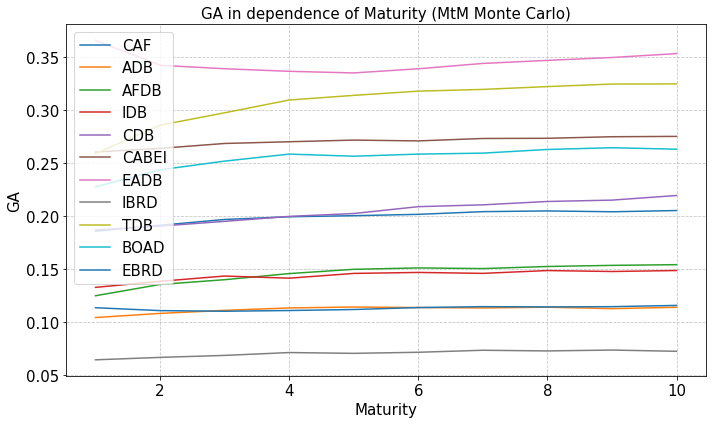

In [17]:
MDBs = bank_names

# Plotting
plt.figure(figsize=(10, 6))
for bank in MDBs:
    plt.plot(maturities, [maturity_results[m].loc["GA MTM Monte Carlo, nu = 0.25"][bank] for m in range(len(maturities))], label=bank)

# Adding labels and title
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.xlabel("Maturity",fontsize=15)
plt.ylabel("GA",fontsize=15)  # Replace with the actual label
plt.title("GA in dependence of Maturity (MtM Monte Carlo)",fontsize=15)

# Adding grid
plt.grid(True, linestyle='--', alpha=0.7)

# Adding legend
plt.legend(fontsize=15)

# Saving and showing the plot
plt.tight_layout()

plt.savefig("mdbs_dependence_on_maturity_mtm.pdf", dpi=300)
plt.show()

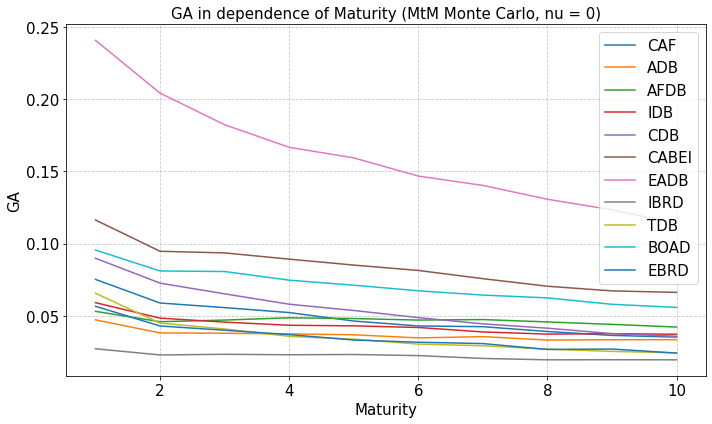

In [18]:
MDBs = bank_names

# Plotting
plt.figure(figsize=(10, 6))
for bank in MDBs:
    plt.plot(maturities, [maturity_results[m].loc["GA MTM Monte Carlo, nu = 0"][bank] for m in range(len(maturities))], label=bank)

# Adding labels and title
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.xlabel("Maturity",fontsize=15)
plt.ylabel("GA",fontsize=15)  # Replace with the actual label
plt.title("GA in dependence of Maturity (MtM Monte Carlo, nu = 0)",fontsize=15)

# Adding grid
plt.grid(True, linestyle='--', alpha=0.7)

# Adding legend
plt.legend(fontsize=15)

# Saving and showing the plot
plt.tight_layout()

plt.savefig("mdbs_dependence_on_maturity_mtm_LGD_const.pdf", dpi=300)
plt.show()

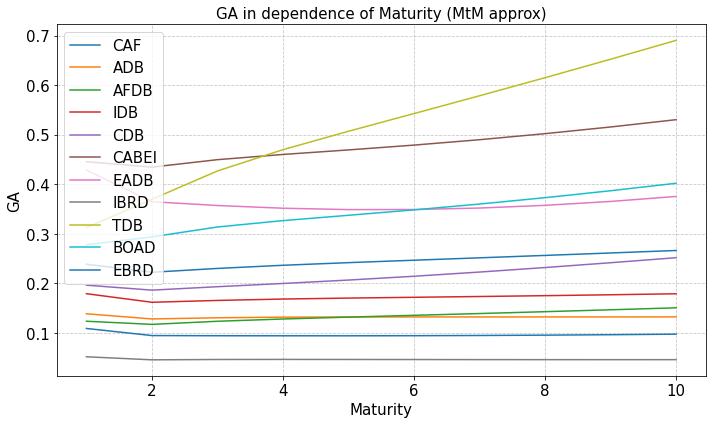

In [19]:
MDBs = bank_names

# Plotting
plt.figure(figsize=(10, 6))
for bank in MDBs:
    plt.plot(maturities, [maturity_results[m].loc["GA MTM Approx. , nu = 0.25"][bank] for m in range(len(maturities))], label=bank)

# Adding labels and title
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.xlabel("Maturity",fontsize=15)
plt.ylabel("GA",fontsize=15)  # Replace with the actual label
plt.title("GA in dependence of Maturity (MtM approx)",fontsize=15)

# Adding grid
plt.grid(True, linestyle='--', alpha=0.7)

# Adding legend
plt.legend(fontsize=15)

# Saving and showing the plot
plt.tight_layout()

plt.savefig("mdbs_dependence_on_maturity_mtm_approx.pdf", dpi=300)
plt.show()

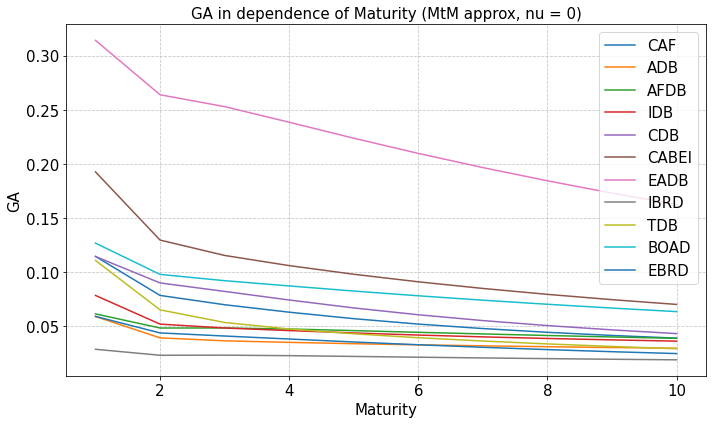

In [20]:
MDBs = bank_names

# Plotting
plt.figure(figsize=(10, 6))
for bank in MDBs:
    plt.plot(maturities, [maturity_results[m].loc["GA MTM Approx. , nu = 0"][bank] for m in range(len(maturities))], label=bank)

# Adding labels and title
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.xlabel("Maturity",fontsize=15)
plt.ylabel("GA",fontsize=15)  # Replace with the actual label
plt.title("GA in dependence of Maturity (MtM approx, nu = 0)",fontsize=15)

# Adding grid
plt.grid(True, linestyle='--', alpha=0.7)

# Adding legend
plt.legend(fontsize=15)

# Saving and showing the plot
plt.tight_layout()

plt.savefig("mdbs_dependence_on_maturity_mtm_approx_LGD_const.pdf", dpi=300)
plt.show()

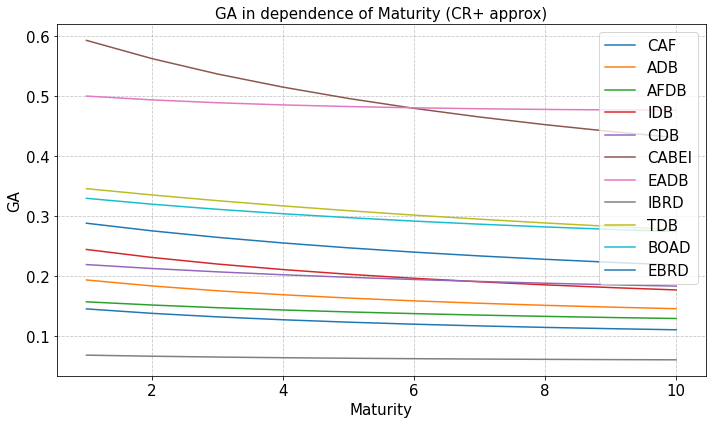

In [21]:
MDBs = bank_names

# Plotting
plt.figure(figsize=(10, 6))
for bank in MDBs:
    plt.plot(maturities, [maturity_results[m].loc["GA approx (rho from IRB, nu = 0.25)"][bank] for m in range(len(maturities))], label=bank)

# Adding labels and title
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.xlabel("Maturity",fontsize=15)
plt.ylabel("GA",fontsize=15)  # Replace with the actual label
plt.title("GA in dependence of Maturity (CR+ approx)",fontsize=15)

# Adding grid
plt.grid(True, linestyle='--', alpha=0.7)

# Adding legend
plt.legend(fontsize=15)

# Saving and showing the plot
plt.tight_layout()

plt.savefig("mdbs_dependence_on_maturity_cr_approx.pdf", dpi=300)
plt.show()

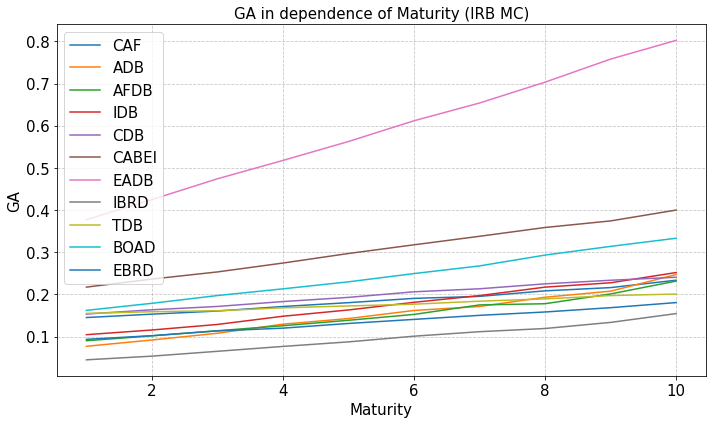

In [22]:
MDBs = bank_names

# Plotting
plt.figure(figsize=(10, 6))
for bank in MDBs:
    plt.plot(maturities, [maturity_results[m].loc["GA Monte Carlo (IRB, nu = 0.25)"][bank] for m in range(len(maturities))], label=bank)

# Adding labels and title
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.xlabel("Maturity",fontsize=15)
plt.ylabel("GA",fontsize=15) # Replace with the actual label
plt.title("GA in dependence of Maturity (IRB MC)",fontsize=15)

# Adding grid
plt.grid(True, linestyle='--', alpha=0.7)

# Adding legend
plt.legend(fontsize=15)

# Saving and showing the plot
plt.tight_layout()

plt.savefig("mdbs_dependence_on_maturity_irb.pdf", dpi=300)
plt.show()

### 1.7) Dependence on coupon rate

Define a Function that only computes the GAs for MtM MC and MtM approx.

In [23]:
def compute_GA_coupons(q=0.99,ELGD_const = 0.45,
               portfolios = portfolios_099,
               trans_dict = SP_dict,
               compute_mtm=True,
               constant_rho = False,
               constant_rho_val = 0.35,
               relative_to_UL = False,
              n_mc = 500000, # For Actuarial Approach
              n_mc_mtm = 500000,
              n_mc_mtm_n1 = 50,
              maturity = 1,
              xi = 0.25,
              coupons = 0.01):
    GA_MTM_approx = []
    GA_MTM = []

    for portfolio in portfolios:
        EAD,ELGD,PD,omega,g = portfolios[portfolio]
        ELGD = np.array([ELGD_const]*len(EAD))
        if len(EAD)>100: # Choose 100 indices
            indices = np.random.choice(range(len(EAD)-1), 100,replace = False)
            EAD = EAD[indices]
            PD = PD[indices]
            omega = omega[indices]
            ELGD = ELGD[indices]
            g = np.array(g)[indices]
        EAD = EAD/np.sum(EAD)
        GA_MTM.append(MC_IS_MtM(ELGD,EAD,
                                    rho = 0.12*(1-np.exp(-50*PD))/(1-np.exp(-50))+0.24*(1-(1-np.exp(-50*PD))/(1-np.exp(-50))),
                                    c = np.array([coupons]*len(EAD)),
                                    g = np.array(g),
                                    D= np.array([maturity]*len(EAD)),                                        
                                    trans_dict = trans_dict,
                                    r= r_nelson,
                                    q=q,T=1,n = n_mc_mtm,n1  = n_mc_mtm_n1,default_only=False))
        GA_MTM_approx.append(GA_GM(PD = PD, ELGD =ELGD, A = EAD, M= np.array([maturity]*len(EAD)),
              q=q,        
             r = r_nelson,
             T=1,
             g= np.array(g),
             trans_prob=trans_dict["trans_prob"],#N times S matrix
             psi = 0.4, # Market Sharpe Ratio,
             rho = 0.12*(1-np.exp(-50*PD))/(1-np.exp(-50))+0.24*(1-(1-np.exp(-50*PD))/(1-np.exp(-50))),
             c = coupons,
            nu = 0.25,
             S = S, # Number of States of Rating
             default_only = False,
              LGD_constant = False))
        df = pd.DataFrame([[len(portfolios[portfolio][0]) for portfolio in portfolios],
                             GA_MTM,GA_MTM_approx], 
                             columns=bank_names, 
                             index = ["Borrowers",
                                    "GA MTM Monte Carlo, nu = 0.25",
                                    "GA MTM Approx. , nu = 0.25"])
                
    return df

In [24]:
coupons_list = np.maximum(np.linspace(0,0.05,11),1e-10)
coupon_results = []
for coupon in coupons_list:
    coupon_results.append(compute_GA_coupons(q=0.999,ELGD_const = 0.45,
               portfolios = portfolios_0999,
               coupons = coupon))   
    

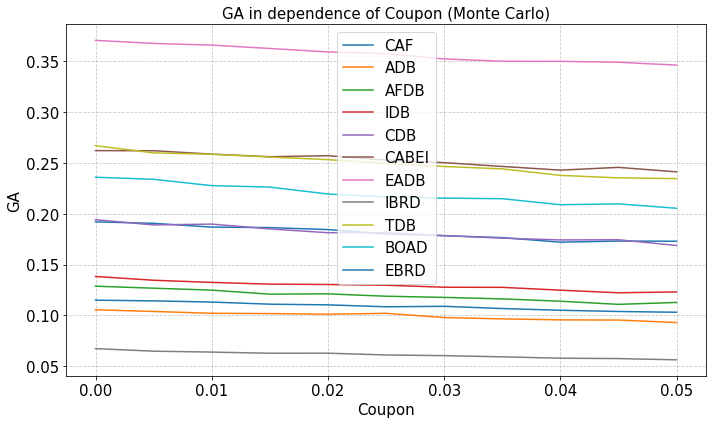

In [25]:
MDBs = bank_names

# Plotting
plt.figure(figsize=(10, 6))
for bank in MDBs:
    plt.plot(coupons_list, [coupon_results[m].loc["GA MTM Monte Carlo, nu = 0.25"][bank] for m in range(len(coupon_results))], label=bank)

# Adding labels and title
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.xlabel("Coupon",fontsize=15)
plt.ylabel("GA",fontsize=15)# Replace with the actual label
plt.title("GA in dependence of Coupon (Monte Carlo)",fontsize=15)

# Adding grid
plt.grid(True, linestyle='--', alpha=0.7)

# Adding legend
plt.legend(fontsize=15)

# Saving and showing the plot
plt.tight_layout()

plt.savefig("mdbs_dependence_on_coupon_mc.pdf", dpi=300)
plt.show()

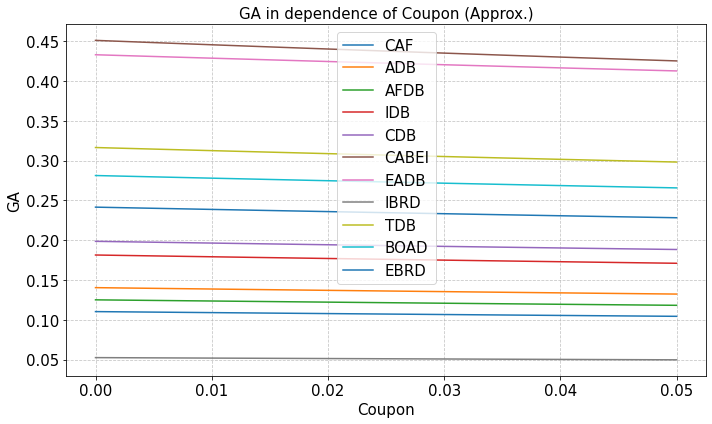

In [26]:
MDBs = bank_names

# Plotting
plt.figure(figsize=(10, 6))
for bank in MDBs:
    plt.plot(coupons_list, [coupon_results[m].loc["GA MTM Approx. , nu = 0.25"][bank] for m in range(len(coupon_results))], label=bank)

# Adding labels and title
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.xlabel("Coupon",fontsize=15)
plt.ylabel("GA",fontsize=15)  # Replace with the actual label
plt.title("GA in dependence of Coupon (Approx.)",fontsize=15)

# Adding grid
plt.grid(True, linestyle='--', alpha=0.7)

# Adding legend
plt.legend(fontsize=15)

# Saving and showing the plot
plt.tight_layout()

plt.savefig("mdbs_dependence_on_coupon_approx.pdf", dpi=300)
plt.show()

### 1.8) Contribution of CondLoss + VaR to GA (in dependence of Maturity)

TDB Portfolio

Maturity  1
Maturity  2
Maturity  3
Maturity  4
Maturity  5


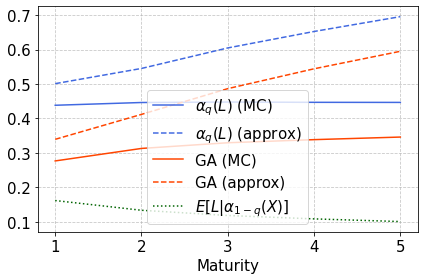

In [27]:
GA_MTM_MC_TDB = []
GA_MTM_approx_TDB = []
nr = 5
for i in range(nr):
    ELGD = portfolios_0999["TDB"][1]
    EAD = portfolios_0999["TDB"][0]
    maturity = i+1
    print("Maturity ", maturity)
    coupons = 0 # 0.01
    g = portfolios_0999["TDB"][4]
    PD = portfolios_0999["TDB"][2]
    GA_MTM_MC_TDB.append(MC_IS_MtM( ELGD =ELGD, EAD = EAD,
         rho = 0.12*(1-np.exp(-50*PD))/(1-np.exp(-50))+0.24*(1-(1-np.exp(-50*PD))/(1-np.exp(-50))),
                                   c = np.array([coupons]*len(EAD)),
                                   g= np.array(g),
                               trans_dict = SP_dict,
                                   D= np.array([maturity]*len(EAD)),
                                        r = lambda x: 0,
          q=0.999,        
         T=1,
         n = 500000,
        nu = 0.25,
         default_only = False,
                              return_cond_loss = True))
    GA_MTM_approx_TDB.append(GA_GM(PD =PD, # Vector of default probabillities
          ELGD =ELGD, #Vector of expected losses given default,
          A = EAD, # Vector of Exposures at default,
          M = np.array([maturity]*len(EAD)), # Vector of Maturities
          q = 0.999, # quantile level          
         r = lambda x: 0, #r_nelson, # interest rate
         T = 1, # Maturity
         g= np.array(g),
         trans_prob =SP_dict["trans_prob"],#N times S matrix
         psi = 0.4, # Market Sharpe Ratio,
         rho = 0.12*(1-np.exp(-50*PD))/(1-np.exp(-50))+0.24*(1-(1-np.exp(-50*PD))/(1-np.exp(-50))),
         nu = 0.25,
         c = coupons,
         S = S, # Number of States of Rating
         second_order = False,
         default_only = False,
          LGD_constant = False))
plt.plot(np.linspace(1,nr,nr),[GA_MTM_MC_TDB[i][0] for i in range(nr)],label = r"$\alpha_q(L)$ (MC)",
         linestyle = "solid",color = "royalblue")
plt.plot(np.linspace(1,nr,nr),[GA_MTM_approx_TDB[i]+GA_MTM_MC_TDB[i][1] for i in range(nr)],label = r"$\alpha_q(L)$ (approx)",
         linestyle = "dashed",color = "royalblue")

plt.plot(np.linspace(1,nr,nr),[GA_MTM_MC_TDB[i][0] - GA_MTM_MC_TDB[i][1] for i in range(nr)],label = "GA (MC)",
         linestyle = "solid",color = "orangered")
plt.plot(np.linspace(1,nr,nr),[GA_MTM_approx_TDB[i] for i in range(nr)],label = "GA (approx)",
         linestyle = "dashed",color = "orangered")

plt.plot(np.linspace(1,nr,nr),[GA_MTM_MC_TDB[i][1] for i in range(nr)],label = r"$E[L|\alpha_{1-q}(X)]$",
         linestyle = "dotted",color = "darkgreen")

# Adding grid
plt.grid(True, linestyle='--', alpha=0.7)

# Adding legend
plt.legend(fontsize=15)
# Adding labels and title
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.xlabel("Maturity",fontsize=15)
# Saving and showing the plot
plt.tight_layout()

plt.savefig("mdbs_dependence_on_maturities_tdb.pdf", dpi=300)
plt.show()

Homogeneous Portfolio with B-rating

Maturity  1
Maturity  2
Maturity  3
Maturity  4
Maturity  5


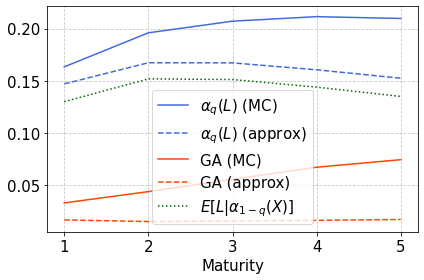

In [28]:
GA_MTM_MC_homo_B_min = []
GA_MTM_approx_homo_B_min = []
nr = 5
obligors = 100
for i in range(nr):
    ELGD = np.array([0.45]*obligors)
    EAD = np.array([0.001]*obligors)
    maturity = i+1
    print("Maturity ", maturity)
    coupons = 0.0
    g = np.array([2]*obligors)
    PD = np.array([0.0759]*obligors)
    GA_MTM_MC_homo_B_min.append(MC_IS_MtM( ELGD =ELGD, EAD = EAD,
         rho = 0.12*(1-np.exp(-50*PD))/(1-np.exp(-50))+0.24*(1-(1-np.exp(-50*PD))/(1-np.exp(-50))),
                                   c = np.array([coupons]*len(EAD)),
                                   g= np.array(g),
                               trans_dict = SP_dict,
                                   D= np.array([maturity]*len(EAD)),
                                        r = lambda x: 0,
          q=0.999,        
         T=1,
         n = 500000,
        nu = 0.25,
         default_only = False,
                              return_cond_loss = True))
    GA_MTM_approx_homo_B_min.append(GA_GM(PD =PD, # Vector of default probabillities
          ELGD =ELGD, #Vector of expected losses given default,
          A = EAD, # Vector of Exposures at default,
          M = np.array([maturity]*len(EAD)), # Vector of Maturities
          q = 0.999, # quantile level          
         r = lambda x: 0,# interest rate
         T = 1, # Maturity
         g= np.array(g),
         trans_prob =SP_dict["trans_prob"],#N times S matrix
         psi = 0.4, # Market Sharpe Ratio,
         rho = 0.12*(1-np.exp(-50*PD))/(1-np.exp(-50))+0.24*(1-(1-np.exp(-50*PD))/(1-np.exp(-50))),
         nu = 0.25,
         c = coupons,
         S = S, # Number of States of Rating
         second_order = False,
         default_only = False,
          LGD_constant = False))
plt.plot(np.linspace(1,nr,nr),[GA_MTM_MC_homo_B_min[i][0] for i in range(nr)],label = r"$\alpha_q(L)$ (MC)",
         linestyle = "solid",color = "royalblue")
plt.plot(np.linspace(1,nr,nr),[GA_MTM_approx_homo_B_min[i]+GA_MTM_MC_homo_B_min[i][1] for i in range(nr)],label = r"$\alpha_q(L)$ (approx)",
         linestyle = "dashed",color = "royalblue")

plt.plot(np.linspace(1,nr,nr),[GA_MTM_MC_homo_B_min[i][0] - GA_MTM_MC_homo_B_min[i][1] for i in range(nr)],label = "GA (MC)",
         linestyle = "solid",color = "orangered")
plt.plot(np.linspace(1,nr,nr),[GA_MTM_approx_homo_B_min[i] for i in range(nr)],label = "GA (approx)",
         linestyle = "dashed",color = "orangered")

plt.plot(np.linspace(1,nr,nr),[GA_MTM_MC_homo_B_min[i][1] for i in range(nr)],label = r"$E[L|\alpha_{1-q}(X)]$",
         linestyle = "dotted",color = "darkgreen")

# Adding grid
plt.grid(True, linestyle='--', alpha=0.7)

# Adding legend
plt.legend(fontsize=15)
# Adding labels and title
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.xlabel("Maturity",fontsize=15)
# Saving and showing the plot
plt.tight_layout()


plt.savefig("mdbs_dependence_on_maturities_homo_B-.pdf", dpi=300)
plt.show()    


Maturity  1
Maturity  2
Maturity  3
Maturity  4
Maturity  5


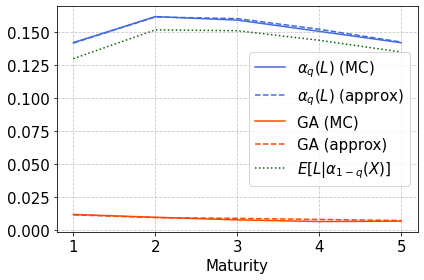

In [29]:
GA_MTM_MC_homo_B_min = []
GA_MTM_approx_homo_B_min = []
nr = 5
obligors = 100
for i in range(nr):
    ELGD = np.array([0.45]*obligors)
    EAD = np.array([0.001]*obligors)
    maturity = i+1
    print("Maturity ", maturity)
    coupons = 0.0
    g = np.array([2]*obligors)
    PD = np.array([0.0759]*obligors)
    GA_MTM_MC_homo_B_min.append(MC_IS_MtM( ELGD =ELGD, EAD = EAD,
         rho = 0.12*(1-np.exp(-50*PD))/(1-np.exp(-50))+0.24*(1-(1-np.exp(-50*PD))/(1-np.exp(-50))),
                                   c = np.array([coupons]*len(EAD)),
                                   g= np.array(g),
                               trans_dict = SP_dict,
                                   D= np.array([maturity]*len(EAD)),
                                        r = lambda x: 0,
          q=0.999,        
         T=1,
         n = 500000,
    LGD_constant = True,
        nu = 0,
         default_only = False,
                              return_cond_loss = True))
    GA_MTM_approx_homo_B_min.append(GA_GM(PD =PD, # Vector of default probabillities
          ELGD =ELGD, #Vector of expected losses given default,
          A = EAD, # Vector of Exposures at default,
          M = np.array([maturity]*len(EAD)), # Vector of Maturities
          q = 0.999, # quantile level          
         r = lambda x: 0,# interest rate
         T = 1, # Maturity
         g= np.array(g),
         trans_prob =SP_dict["trans_prob"],#N times S matrix
         psi = 0.4, # Market Sharpe Ratio,
         rho = 0.12*(1-np.exp(-50*PD))/(1-np.exp(-50))+0.24*(1-(1-np.exp(-50*PD))/(1-np.exp(-50))),
         nu = 0,
         c = coupons,
         S = S, # Number of States of Rating
         second_order = False,
         default_only = False,
          LGD_constant = True))
plt.plot(np.linspace(1,nr,nr),[GA_MTM_MC_homo_B_min[i][0] for i in range(nr)],label = r"$\alpha_q(L)$ (MC)",
         linestyle = "solid",color = "royalblue")
plt.plot(np.linspace(1,nr,nr),[GA_MTM_approx_homo_B_min[i]+GA_MTM_MC_homo_B_min[i][1] for i in range(nr)],label = r"$\alpha_q(L)$ (approx)",
         linestyle = "dashed",color = "royalblue")

plt.plot(np.linspace(1,nr,nr),[GA_MTM_MC_homo_B_min[i][0] - GA_MTM_MC_homo_B_min[i][1] for i in range(nr)],label = "GA (MC)",
         linestyle = "solid",color = "orangered")
plt.plot(np.linspace(1,nr,nr),[GA_MTM_approx_homo_B_min[i] for i in range(nr)],label = "GA (approx)",
         linestyle = "dashed",color = "orangered")

plt.plot(np.linspace(1,nr,nr),[GA_MTM_MC_homo_B_min[i][1] for i in range(nr)],label = r"$E[L|\alpha_{1-q}(X)]$",
         linestyle = "dotted",color = "darkgreen")

# Adding grid
plt.grid(True, linestyle='--', alpha=0.7)

# Adding legend
plt.legend(fontsize=15)
# Adding labels and title
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.xlabel("Maturity",fontsize=15)
# Saving and showing the plot
plt.tight_layout()


plt.savefig("mdbs_dependence_on_maturities_homo_B-_const_lgd.pdf", dpi=300)
plt.show()    


Homogeneous Portfolio with BB- rating

Maturity  1
Maturity  2
Maturity  3
Maturity  4
Maturity  5


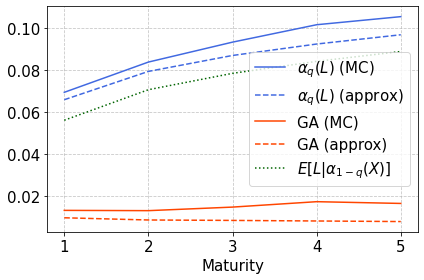

In [30]:
GA_MTM_MC_homo_BB_min = []
GA_MTM_approx_homo_BB_min = []
nr = 5
obligors = 100
for i in range(nr):
    ELGD = np.array([0.45]*obligors)
    EAD = np.array([0.001]*obligors)
    maturity = i+1
    print("Maturity ", maturity)
    coupons = 0.0
    g = np.array([5]*obligors)
    PD = np.array([9.000e-03]*obligors)
    GA_MTM_MC_homo_BB_min.append(MC_IS_MtM( ELGD =ELGD, EAD = EAD,
         rho = 0.12*(1-np.exp(-50*PD))/(1-np.exp(-50))+0.24*(1-(1-np.exp(-50*PD))/(1-np.exp(-50))),
                                   c = np.array([coupons]*len(EAD)),
                                   g= np.array(g),
                               trans_dict = SP_dict,
                                   D= np.array([maturity]*len(EAD)),
                                        r = lambda x: 0,
          q=0.999,        
         T=1,
         n = 500000,
        nu = 0.25,
         default_only = False,
                              return_cond_loss = True))
    GA_MTM_approx_homo_BB_min.append(GA_GM(PD =PD, # Vector of default probabillities
          ELGD =ELGD, #Vector of expected losses given default,
          A = EAD, # Vector of Exposures at default,
          M = np.array([maturity]*len(EAD)), # Vector of Maturities
          q = 0.999, # quantile level          
         r = lambda x: 0,# interest rate
         T = 1, # Maturity
         g= np.array(g),
         trans_prob =SP_dict["trans_prob"],#N times S matrix
         psi = 0.4, # Market Sharpe Ratio,
         rho = 0.12*(1-np.exp(-50*PD))/(1-np.exp(-50))+0.24*(1-(1-np.exp(-50*PD))/(1-np.exp(-50))),
         nu = 0.25,
         c = coupons,
         S = S, # Number of States of Rating
         second_order = False,
         default_only = False,
          LGD_constant = False))
plt.plot(np.linspace(1,nr,nr),[GA_MTM_MC_homo_BB_min[i][0] for i in range(nr)],label = r"$\alpha_q(L)$ (MC)",
         linestyle = "solid",color = "royalblue")
plt.plot(np.linspace(1,nr,nr),[GA_MTM_approx_homo_BB_min[i]+GA_MTM_MC_homo_BB_min[i][1] for i in range(nr)],label = r"$\alpha_q(L)$ (approx)",
         linestyle = "dashed",color = "royalblue")

plt.plot(np.linspace(1,nr,nr),[GA_MTM_MC_homo_BB_min[i][0] - GA_MTM_MC_homo_BB_min[i][1] for i in range(nr)],label = "GA (MC)",
         linestyle = "solid",color = "orangered")
plt.plot(np.linspace(1,nr,nr),[GA_MTM_approx_homo_BB_min[i] for i in range(nr)],label = "GA (approx)",
         linestyle = "dashed",color = "orangered")

plt.plot(np.linspace(1,nr,nr),[GA_MTM_MC_homo_BB_min[i][1] for i in range(nr)],label = r"$E[L|\alpha_{1-q}(X)]$",
         linestyle = "dotted",color = "darkgreen")

# Adding grid
plt.grid(True, linestyle='--', alpha=0.7)

# Adding legend
plt.legend(fontsize=15)
# Adding labels and title
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.xlabel("Maturity",fontsize=15)
# Saving and showing the plot
plt.tight_layout()


plt.savefig("mdbs_dependence_on_maturities_homo_BB-.pdf", dpi=300)
plt.show()    


Maturity  1
Maturity  2
Maturity  3
Maturity  4
Maturity  5


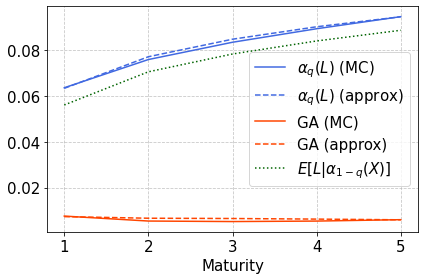

In [31]:
GA_MTM_MC_homo_BB_min = []
GA_MTM_approx_homo_BB_min = []
nr = 5
obligors = 100
for i in range(nr):
    ELGD = np.array([0.45]*obligors)
    EAD = np.array([0.001]*obligors)
    maturity = i+1
    print("Maturity ", maturity)
    coupons = 0.0
    g = np.array([5]*obligors)
    PD = np.array([9.000e-03]*obligors)
    GA_MTM_MC_homo_BB_min.append(MC_IS_MtM( ELGD =ELGD, EAD = EAD,
         rho = 0.12*(1-np.exp(-50*PD))/(1-np.exp(-50))+0.24*(1-(1-np.exp(-50*PD))/(1-np.exp(-50))),
                                   c = np.array([coupons]*len(EAD)),
                                   g= np.array(g),
                               trans_dict = SP_dict,
                                   D= np.array([maturity]*len(EAD)),
                                        r = lambda x: 0,
          q=0.999,        
         T=1,
         n = 500000,
        nu = 0,
    LGD_constant = True,
         default_only = False,
                              return_cond_loss = True))
    GA_MTM_approx_homo_BB_min.append(GA_GM(PD =PD, # Vector of default probabillities
          ELGD =ELGD, #Vector of expected losses given default,
          A = EAD, # Vector of Exposures at default,
          M = np.array([maturity]*len(EAD)), # Vector of Maturities
          q = 0.999, # quantile level          
         r = lambda x: 0,# interest rate
         T = 1, # Maturity
         g= np.array(g),
         trans_prob =SP_dict["trans_prob"],#N times S matrix
         psi = 0.4, # Market Sharpe Ratio,
         rho = 0.12*(1-np.exp(-50*PD))/(1-np.exp(-50))+0.24*(1-(1-np.exp(-50*PD))/(1-np.exp(-50))),
         nu = 0,
         c = coupons,
         S = S, # Number of States of Rating
         second_order = False,
         default_only = False,
          LGD_constant = True))
plt.plot(np.linspace(1,nr,nr),[GA_MTM_MC_homo_BB_min[i][0] for i in range(nr)],label = r"$\alpha_q(L)$ (MC)",
         linestyle = "solid",color = "royalblue")
plt.plot(np.linspace(1,nr,nr),[GA_MTM_approx_homo_BB_min[i]+GA_MTM_MC_homo_BB_min[i][1] for i in range(nr)],label = r"$\alpha_q(L)$ (approx)",
         linestyle = "dashed",color = "royalblue")

plt.plot(np.linspace(1,nr,nr),[GA_MTM_MC_homo_BB_min[i][0] - GA_MTM_MC_homo_BB_min[i][1] for i in range(nr)],label = "GA (MC)",
         linestyle = "solid",color = "orangered")
plt.plot(np.linspace(1,nr,nr),[GA_MTM_approx_homo_BB_min[i] for i in range(nr)],label = "GA (approx)",
         linestyle = "dashed",color = "orangered")

plt.plot(np.linspace(1,nr,nr),[GA_MTM_MC_homo_BB_min[i][1] for i in range(nr)],label = r"$E[L|\alpha_{1-q}(X)]$",
         linestyle = "dotted",color = "darkgreen")

# Adding grid
plt.grid(True, linestyle='--', alpha=0.7)

# Adding legend
plt.legend(fontsize=15)
# Adding labels and title
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.xlabel("Maturity",fontsize=15)
# Saving and showing the plot
plt.tight_layout()


plt.savefig("mdbs_dependence_on_maturities_homo_BB-_const_lgd.pdf", dpi=300)
plt.show()    


Homogeneous Portfolio with AA rating

Maturity  1
Maturity  2
Maturity  3
Maturity  4
Maturity  5


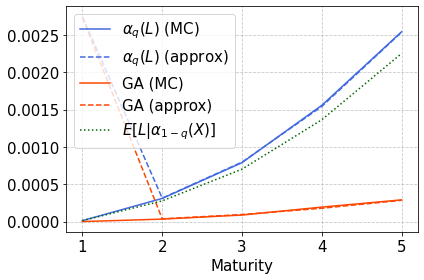

In [32]:
GA_MTM_MC_homo_AA = []
GA_MTM_approx_homo_AA  = []
nr = 5
obligors = 100
for i in range(nr):
    ELGD = np.array([0.45]*obligors)
    EAD = np.array([0.001]*obligors)
    maturity = i+1
    print("Maturity ", maturity)
    coupons = 0
    g = np.array([15]*obligors) 
    PD = np.array([0.00000000001]*obligors)
    GA_MTM_MC_homo_AA .append(MC_IS_MtM( ELGD =ELGD, EAD = EAD,
         rho = 0.12*(1-np.exp(-50*PD))/(1-np.exp(-50))+0.24*(1-(1-np.exp(-50*PD))/(1-np.exp(-50))),
                                   c = np.array([coupons]*len(EAD)),
                                   g= np.array(g),
                               trans_dict = SP_dict,
                                   D= np.array([maturity]*len(EAD)),
                                        r = lambda x: 0,# interest rate,
          q=0.999,        
         T=1,
         n = 500000,
        nu = 0.25,
         default_only = False,
                              return_cond_loss = True))
    GA_MTM_approx_homo_AA .append(GA_GM(PD =PD, # Vector of default probabillities
          ELGD =ELGD, #Vector of expected losses given default,
          A = EAD, # Vector of Exposures at default,
          M = np.array([maturity]*len(EAD)), # Vector of Maturities
          q = 0.999, # quantile level          
         r = lambda x: 0,# interest rate, # interest rate
         T = 1, # Maturity
         g= np.array(g),
         trans_prob =SP_dict["trans_prob"],#N times S matrix
         psi = 0.4, # Market Sharpe Ratio,
         rho = 0.12*(1-np.exp(-50*PD))/(1-np.exp(-50))+0.24*(1-(1-np.exp(-50*PD))/(1-np.exp(-50))),
         nu = 0.25,
         c = coupons,
         S = S, # Number of States of Rating
         second_order = False,
         default_only = False,
          LGD_constant = False))
plt.plot(np.linspace(1,nr,nr),[GA_MTM_MC_homo_AA [i][0] for i in range(nr)],label = r"$\alpha_q(L)$ (MC)",
         linestyle = "solid",color = "royalblue")
plt.plot(np.linspace(1,nr,nr),[GA_MTM_approx_homo_AA [i]+GA_MTM_MC_homo_AA [i][1] for i in range(nr)],label = r"$\alpha_q(L)$ (approx)",
         linestyle = "dashed",color = "royalblue")

plt.plot(np.linspace(1,nr,nr),[GA_MTM_MC_homo_AA [i][0] - GA_MTM_MC_homo_AA [i][1] for i in range(nr)],label = "GA (MC)",
         linestyle = "solid",color = "orangered")
plt.plot(np.linspace(1,nr,nr),[GA_MTM_approx_homo_AA [i] for i in range(nr)],label = "GA (approx)",
         linestyle = "dashed",color = "orangered")

plt.plot(np.linspace(1,nr,nr),[GA_MTM_MC_homo_AA [i][1] for i in range(nr)],label = r"$E[L|\alpha_{1-q}(X)]$",
         linestyle = "dotted",color = "darkgreen")

# Adding grid
plt.grid(True, linestyle='--', alpha=0.7)

# Adding legend
plt.legend(fontsize=15)
# Adding labels and title
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.xlabel("Maturity",fontsize=15)
# Saving and showing the plot
plt.tight_layout()


plt.savefig("mdbs_dependence_on_maturities_homo_AA.pdf", dpi=300)
plt.show()    


## 2.) q = 99.9 %, ELGD = 0.1

In [33]:
df_999_lgd01 = compute_GA(q=0.999,ELGD_const = 0.1,
               portfolios = portfolios_0999,
                          trans_dict = RC_dict)
display(df_999_lgd01)

,CAF,ADB,AFDB,IDB,CDB,CABEI,EADB,IBRD,TDB,BOAD,EBRD
Borrowers,16.00,38.00,29.00,26.00,16.00,11.00,4.00,78.00,21.00,8.00,37.00
"GA approx (rho from IRB, VLGD = 0)",4.29,2.85,2.35,3.61,3.36,8.74,8.20,1.04,4.99,4.89,2.21
"GA approx (omega as Input , VLGD = 0)",4.39,2.91,2.34,3.70,3.38,8.84,8.20,1.04,5.00,4.89,2.16
"GA approx (rho from IRB, nu = 0.25)",19.80,13.45,10.66,16.97,14.44,41.34,29.58,4.48,24.74,22.77,9.67
"GA approx (rho from IRB, nu = 0.25, 2nd order)",172.44,154.27,67.63,198.16,87.16,696.40,517.67,20.76,167.02,159.30,76.37
"GA approx (simplified, nu = 0.25)",13.94,9.27,7.65,11.72,10.91,28.40,26.65,3.38,16.22,15.89,7.18
"GA approx (simplified, nu = 0)",4.29,2.85,2.35,3.61,3.36,8.74,8.20,1.04,4.99,4.89,2.21
"GA Monte Carlo (CR+, rho from IRB, nu = 0.25)",4.55,2.49,3.26,3.29,4.69,5.91,6.24,1.65,5.74,5.59,2.70
"GA Monte Carlo (CR+, omega as Input, nu = 0.25)",4.58,2.50,3.27,3.28,4.68,5.92,6.24,1.63,5.72,5.56,2.71
"GA Monte Carlo (CR+, rho from IRB, LGD constant)",1.28,0.98,1.02,1.12,1.36,2.44,3.71,0.62,0.79,1.63,1.05


Relative to UL

In [ ]:
df_999_lgd01_UL = compute_GA(q=0.999,ELGD_const = 0.1,
               portfolios = portfolios_0999,
                compute_mtm= False,
               relative_to_UL = True,
                          trans_dict = RC_dict)
display(df_999_lgd01_UL )            

Calibration of Xi

In [ ]:
maturity_for_missing_vals = np.mean([5.09,8.20,5.62,8.48,5.39,2.82,7.08,1.64,4.59]) # determine a maturity that should be used for the banks without information
maturities = np.array([5.09,8.20,5.62,8.48,maturity_for_missing_vals,5.39,2.82,7.08,1.64,4.59,maturity_for_missing_vals])
calibrated_xi = calibrate_xi(q=0.999,ELGD_const = 0.1,
               portfolios = portfolios_0999,
              maturities = maturities)
print("The calibrated xi is {}".format(calibrated_xi))

### 2.1) Constant Rho, Rho = 0.35

In [ ]:
df_999_lgd01_rho = compute_GA(q=0.999,ELGD_const = 0.1,
               portfolios = portfolios_0999_rho035,
               constant_rho = True,
               constant_rho_val = 0.35,
                          trans_dict = RC_dict)
display(df_999_lgd01_rho)

Relative to UL

In [ ]:
df_999_lgd01_rho_UL = compute_GA(q=0.999,ELGD_const = 0.1,
               portfolios = portfolios_0999_rho035,
               constant_rho = True,
               constant_rho_val = 0.35,
                compute_mtm= False,
               relative_to_UL = True,
                          trans_dict = RC_dict)
display(df_999_lgd01_rho_UL)

# Dependence on Maturity

In [ ]:
maturities = np.arange(1,11)
maturity_results_lgd01 = []
for mat in maturities:
    maturity_results_lgd01.append(compute_GA_maturities(q=0.999,ELGD_const = 0.45,
               portfolios = portfolios_0999,
               maturity = mat))

In [ ]:
MDBs = bank_names

# Plotting
plt.figure(figsize=(10, 6))
for bank in MDBs:
    plt.plot(maturities, [maturity_results_lgd01[m].loc["GA MTM Monte Carlo, nu = 0.25, ELGD = 0.1"][bank] for m in range(len(maturities))], label=bank)

# Adding labels and title
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.xlabel("Maturity",fontsize=15)
plt.ylabel("GA",fontsize=15)  # Replace with the actual label
plt.title("GA in dependence of Maturity (MtM Monte Carlo)",fontsize=15)

# Adding grid
plt.grid(True, linestyle='--', alpha=0.7)

# Adding legend
plt.legend(fontsize=15)

# Saving and showing the plot
plt.tight_layout()

plt.savefig("mdbs_dependence_on_maturity_mtm_lgd01.pdf", dpi=300)
plt.show()

In [ ]:
MDBs = bank_names

# Plotting
plt.figure(figsize=(10, 6))
for bank in MDBs:
    plt.plot(maturities, [maturity_results_lgd01[m].loc["GA MTM Monte Carlo, nu = 0, ELGD = 0.1"][bank] for m in range(len(maturities))], label=bank)

# Adding labels and title
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.xlabel("Maturity",fontsize=15)
plt.ylabel("GA",fontsize=15)  # Replace with the actual label
plt.title("GA in dependence of Maturity (MtM Monte Carlo, nu = 0)",fontsize=15)

# Adding grid
plt.grid(True, linestyle='--', alpha=0.7)

# Adding legend
plt.legend(fontsize=15)

# Saving and showing the plot
plt.tight_layout()

plt.savefig("mdbs_dependence_on_maturity_mtm_LGD_const_lgd01.pdf", dpi=300)
plt.show()

In [ ]:
MDBs = bank_names

# Plotting
plt.figure(figsize=(10, 6))
for bank in MDBs:
    plt.plot(maturities, [maturity_results_lgd01[m].loc["GA MTM Approx., nu = 0.25, ELGD = 0.1"][bank] for m in range(len(maturities))], label=bank)

# Adding labels and title
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.xlabel("Maturity",fontsize=15)
plt.ylabel("GA",fontsize=15)  # Replace with the actual label
plt.title("GA in dependence of Maturity (MtM approx)",fontsize=15)

# Adding grid
plt.grid(True, linestyle='--', alpha=0.7)

# Adding legend
plt.legend(fontsize=15)

# Saving and showing the plot
plt.tight_layout()

plt.savefig("mdbs_dependence_on_maturity_mtm_approx_lgd01.pdf", dpi=300)
plt.show()

In [ ]:
MDBs = bank_names

# Plotting
plt.figure(figsize=(10, 6))
for bank in MDBs:
    plt.plot(maturities, [maturity_results_lgd01[m].loc["GA MTM Approx. , nu = 0, ELGD = 0.1"][bank] for m in range(len(maturities))], label=bank)

# Adding labels and title
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.xlabel("Maturity",fontsize=15)
plt.ylabel("GA",fontsize=15)  # Replace with the actual label
plt.title("GA in dependence of Maturity (MtM approx, nu = 0)",fontsize=15)

# Adding grid
plt.grid(True, linestyle='--', alpha=0.7)

# Adding legend
plt.legend(fontsize=15)

# Saving and showing the plot
plt.tight_layout()

plt.savefig("mdbs_dependence_on_maturity_mtm_approx_LGD_const_lgd01.pdf", dpi=300)
plt.show()

In [ ]:
MDBs = bank_names

# Plotting
plt.figure(figsize=(10, 6))
for bank in MDBs:
    plt.plot(maturities, [maturity_results_lgd01[m].loc["GA approx (rho from IRB, nu = 0.25, ELGD = 0.1)"][bank] for m in range(len(maturities))], label=bank)

# Adding labels and title
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.xlabel("Maturity",fontsize=15)
plt.ylabel("GA",fontsize=15)  # Replace with the actual label
plt.title("GA in dependence of Maturity (CR+ approx)",fontsize=15)

# Adding grid
plt.grid(True, linestyle='--', alpha=0.7)

# Adding legend
plt.legend(fontsize=15)

# Saving and showing the plot
plt.tight_layout()

plt.savefig("mdbs_dependence_on_maturity_cr_approx_lgd01.pdf", dpi=300)
plt.show()

In [ ]:
MDBs = bank_names

# Plotting
plt.figure(figsize=(10, 6))
for bank in MDBs:
    plt.plot(maturities, [maturity_results_lgd01[m].loc["GA Monte Carlo (IRB, nu = 0.25, ELGD = 0.1)"][bank] for m in range(len(maturities))], label=bank)

# Adding labels and title
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.xlabel("Maturity",fontsize=15)
plt.ylabel("GA",fontsize=15) # Replace with the actual label
plt.title("GA in dependence of Maturity (IRB MC)",fontsize=15)

# Adding grid
plt.grid(True, linestyle='--', alpha=0.7)

# Adding legend
plt.legend(fontsize=15)

# Saving and showing the plot
plt.tight_layout()

plt.savefig("mdbs_dependence_on_maturity_irb.pdf_lgd01", dpi=300)
plt.show()

# GA Computations for RC Transition Matrix

## 3.) q = 99.9 %, ELGD = 0.1

In [ ]:
df_999_lgd01_RC = compute_GA(q=0.999,ELGD_const = 0.1,
               portfolios = portfolios_0999_RC,compute_mtm=True,
                          trans_dict = RC_dict)
display(df_999_lgd01_RC)

Relative to UL

In [ ]:
df_999_lgd01_RC_UL = compute_GA(q=0.999,ELGD_const = 0.1,
               portfolios = portfolios_0999_RC,compute_mtm=False,
               relative_to_UL = True,
                          trans_dict = RC_dict)
display(df_999_lgd01_RC_UL)